In [ ]:
import glob
import os
from tempfile import NamedTemporaryFile
import shutil
import csv
import preprocess as pp
import matplotlib.pyplot


In [2]:
# files location E= D:\Users\Matan\Downloads\preprocess files test\
# The function gets a row as a dictionary and adds/updates the DB by it
def updateDB(dictionary):
    # sets all the fields of the Data Base
    fields = ["Animal", "Date", "lfp", "Bandpass", "median", "files recorded",
              "Bad electrodes", "Crosstalk", "possible spiking channels", "Neurons after sorting"]
    # The Data Base's path
    DBPath = "D:\\Users\\Matan\\Downloads\\preprocess files test\\ThemisDB.csv"
    # Creates temporary file
    tempFile = NamedTemporaryFile(mode='w', delete=False, newline='')
    # reads from the DB
    with open(DBPath, 'r')as csvFile:
        writer = csv.DictWriter(tempFile, fieldnames=fields)
        reader = csv.DictReader(csvFile, fieldnames=fields)
        isUpdated = False
        for row in reader:
            # if the row exists in the DB, update it
            if row["Animal"] == str(dictionary.get("Animal")) and row["Date"] == str(dictionary.get("Date")):
                for key in dictionary.keys():
                    row.update({key: dictionary.get(key)})
                isUpdated = True
            # write the row to the temp file
            writer.writerow(row)
        # if the row does not exist in the DB, add it
        if not isUpdated:
            writer.writerow(dictionary)
    # close the temp file and replace it in the DB folder
    tempFile.close()
    shutil.move(tempFile.name, DBPath)
    print("ThemisDB.csv has been updated")

In [3]:
# inDir = input("Enter a Wireless Recordings path:")
inDir = "D:\\Users\\Matan\\Downloads\\preprocess files test\\"
# count the DT2 files
DT2Files = [f for f in glob.glob(inDir + "\\*.DT2")]
# create a list of numbers from 0 to the number of DT2 files
fileList = list(range(0, DT2Files.__len__()))
# create a list of electrodes numbers from 2 to 33
elecList = list(range(2, 33))
# example for a basic row Data
basicRow = {"Animal": "K6", "Date": "20/03/2020"}
rangeStr = "-F{0}T{1}".format(fileList[0], fileList[-1])

In [7]:
pp.wirelessToBin(inDir, inDir + "binNew\\", fileList, elecList)
basicRow.update({"files recorded": fileList.__len__()})
updateDB(basicRow)
print(str(fileList.__len__()) + " files has been converted from wireless to bin successfully")

ThemisDB.csv has been updated
6 files has been converted from wireless to bin successfully


In [5]:
fileFormat = '{0}Elec{1}' + rangeStr + '.bin'
pp.binToLFP(inDir + "binNew\\", inDir + "binLFP\\", fileFormat, elecList)
basicRow.update({"lfp": elecList.__len__()})
updateDB(basicRow)
print(str(elecList.__len__()) + " files has been converted from lfp to bin successfully")

ThemisDB.csv has been updated
31 files has been transformed from lfp to bin successfully


In [6]:
fileFormat = "Elec{0}" + rangeStr + ".bin"
pp.bandpass_filter(inDir + "binNew\\", inDir + "binBand\\", fileFormat, elecList)
basicRow.update({"Bandpass": elecList.__len__()})
updateDB(basicRow)
print(str(elecList.__len__()) + " files has been converted from bandpass to bin successfully")

ThemisDB.csv has been updated
31 files has been transformed from bandpass to bin successfully


In [4]:
def showElectrode(path, elecNumber, plotLimit, title):
    fig, axes = pp.plotBin(path, plotLimit)
    axes.set_title('Electrode ' + str(elecNumber) + title, fontsize=20)
    fig.set_size_inches((30, 5))
    matplotlib.pyplot.show()

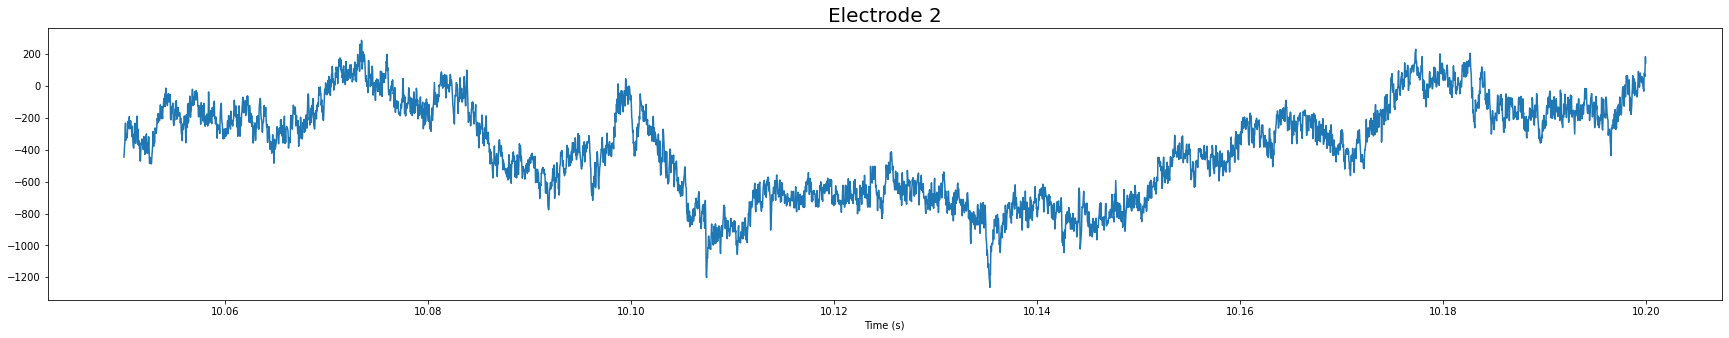

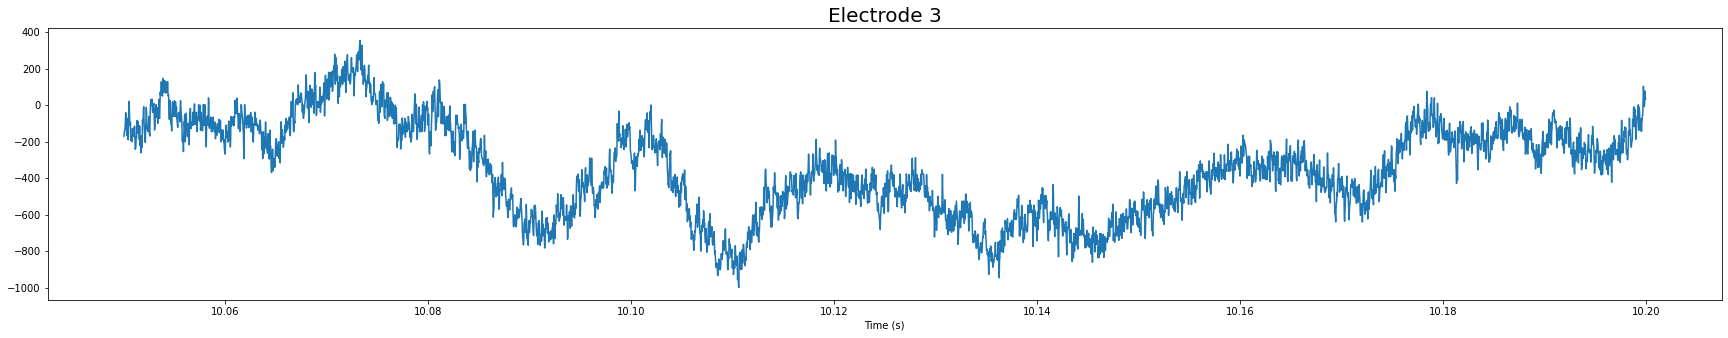

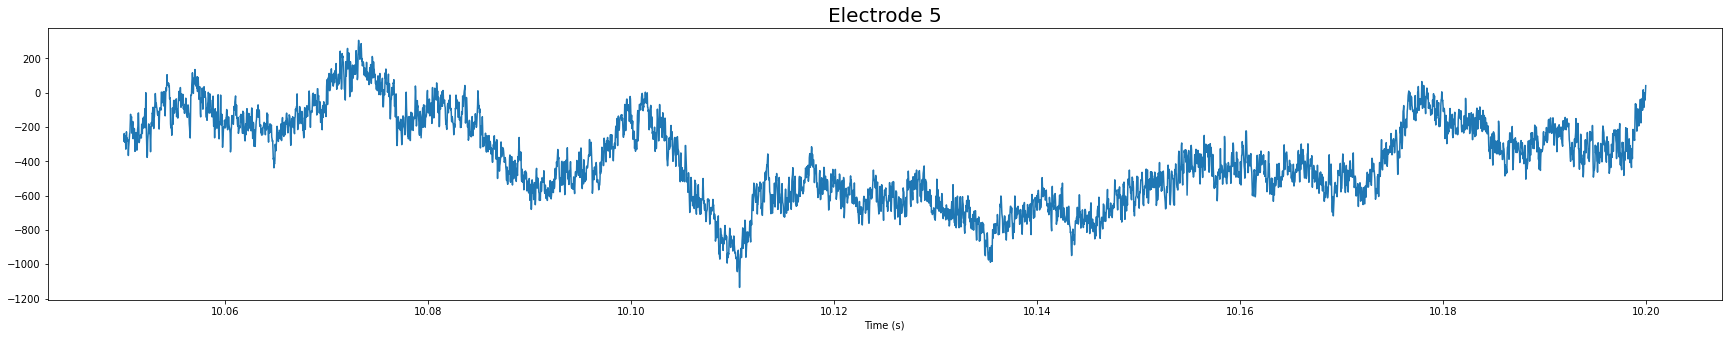

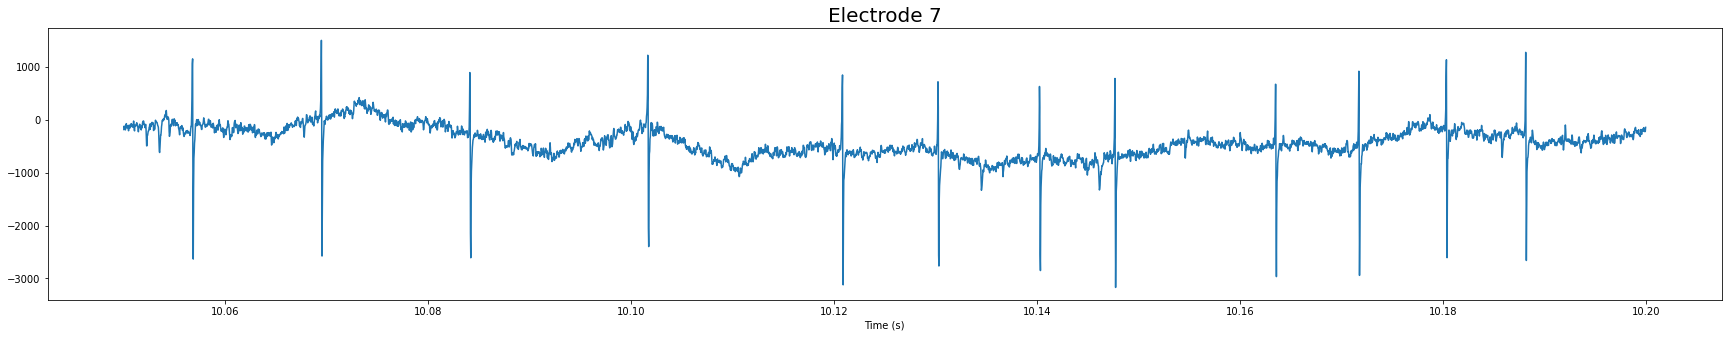

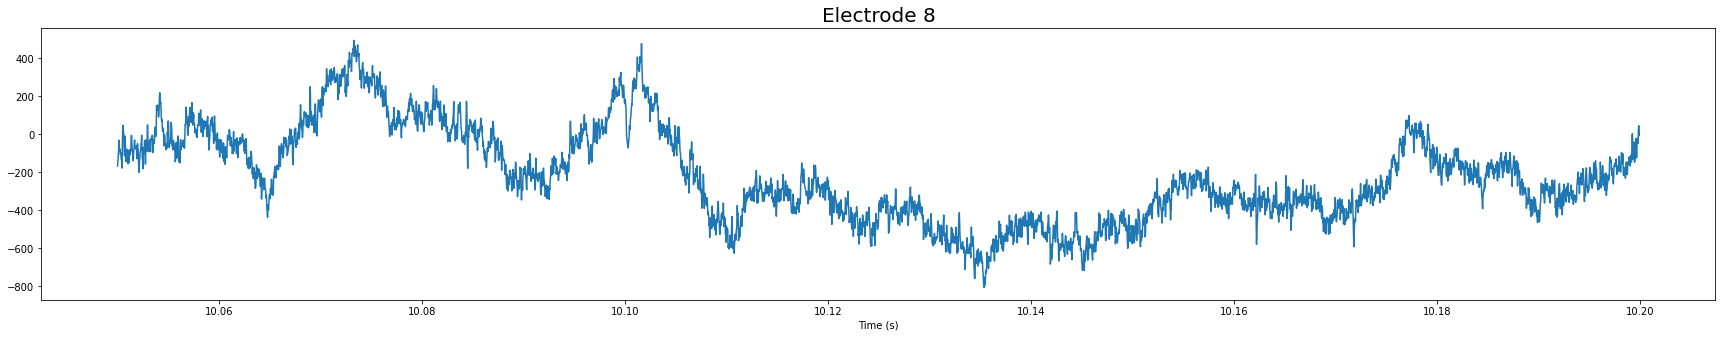

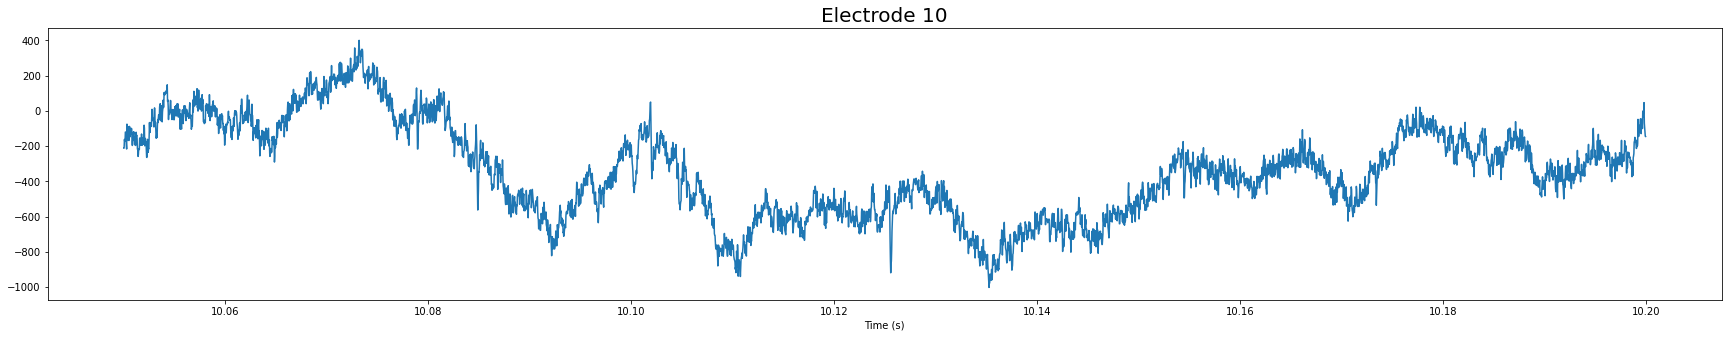

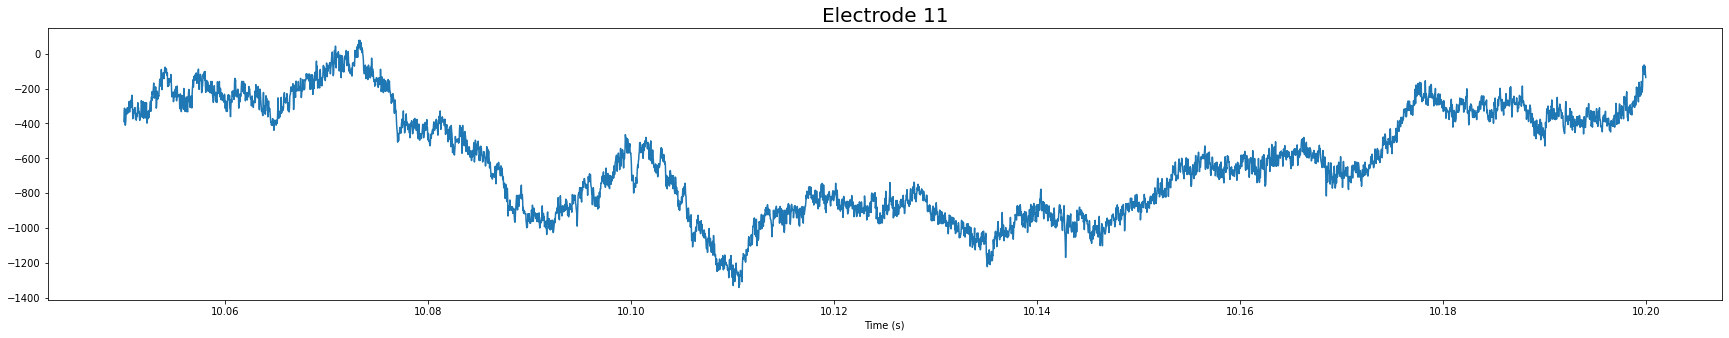

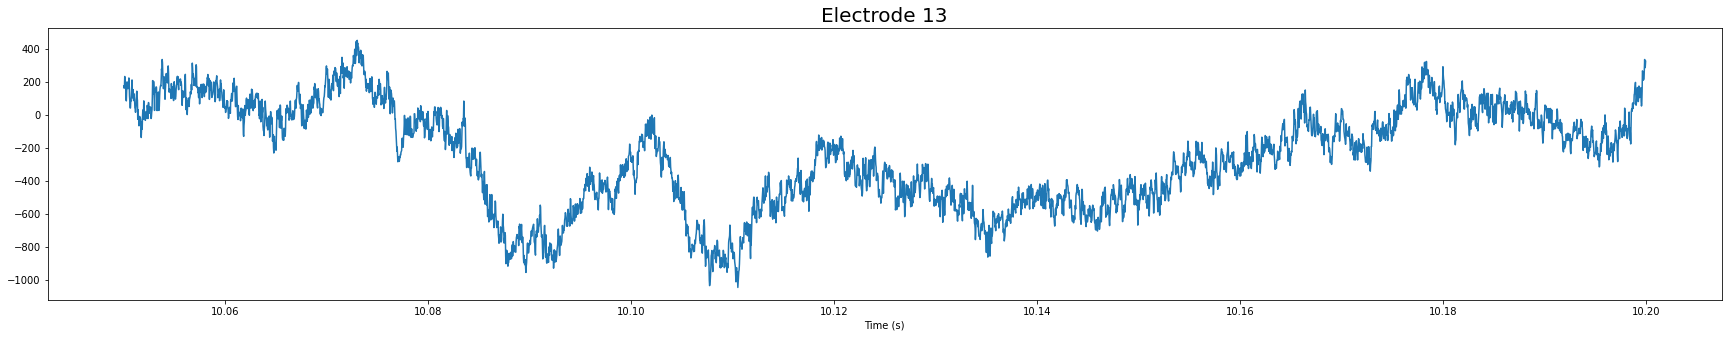

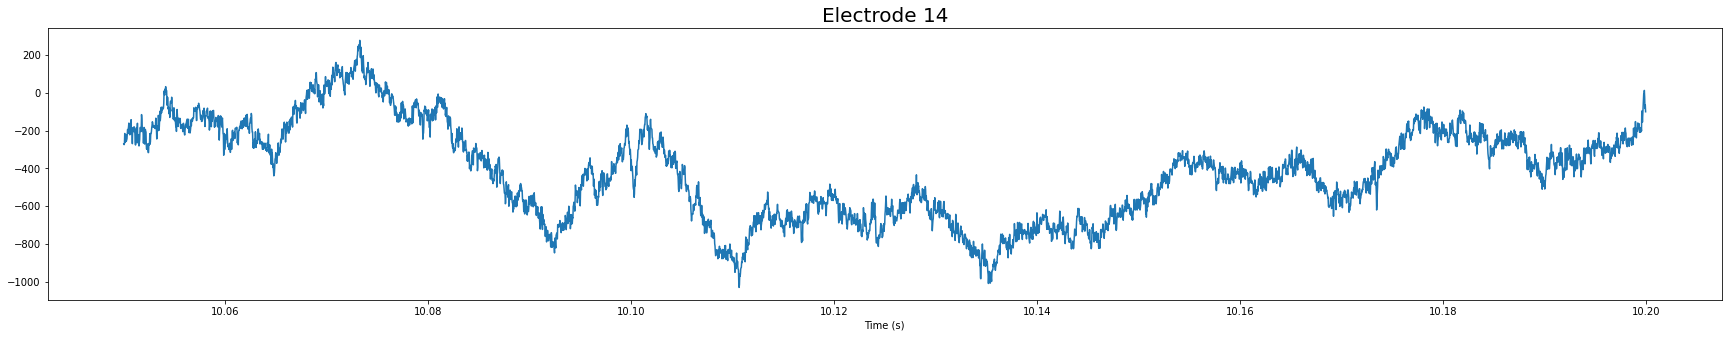

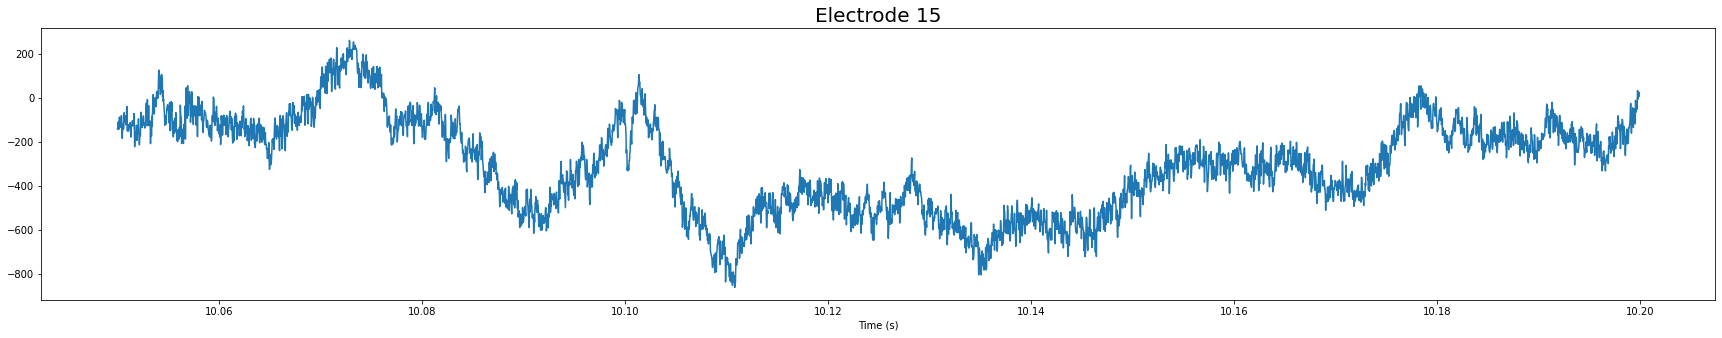

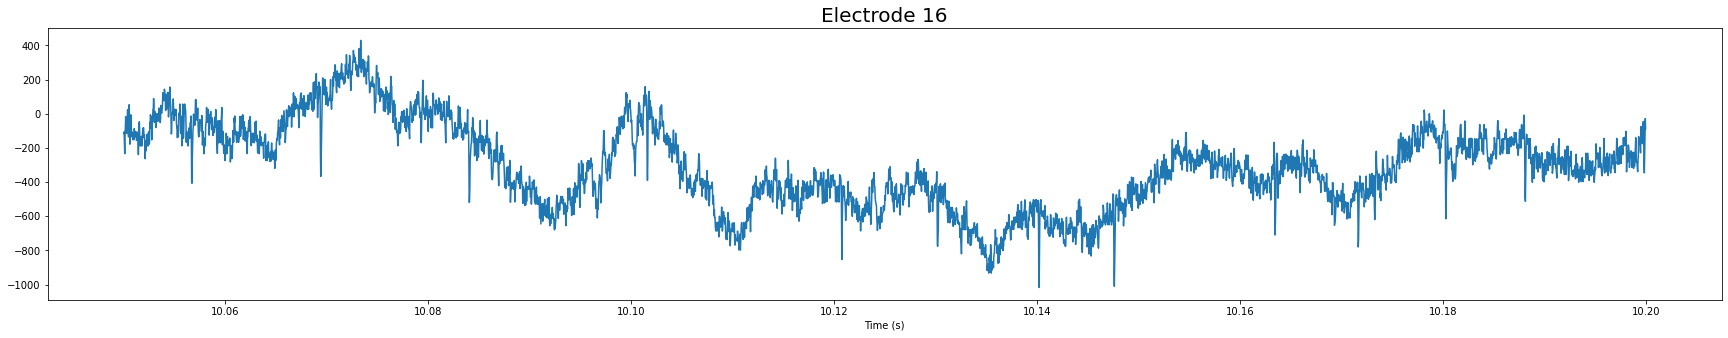

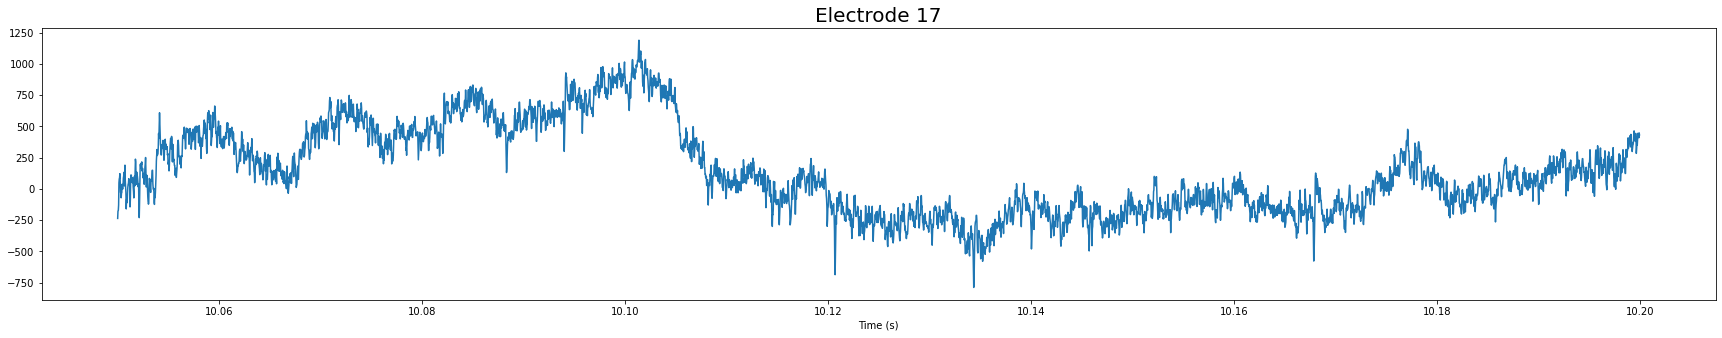

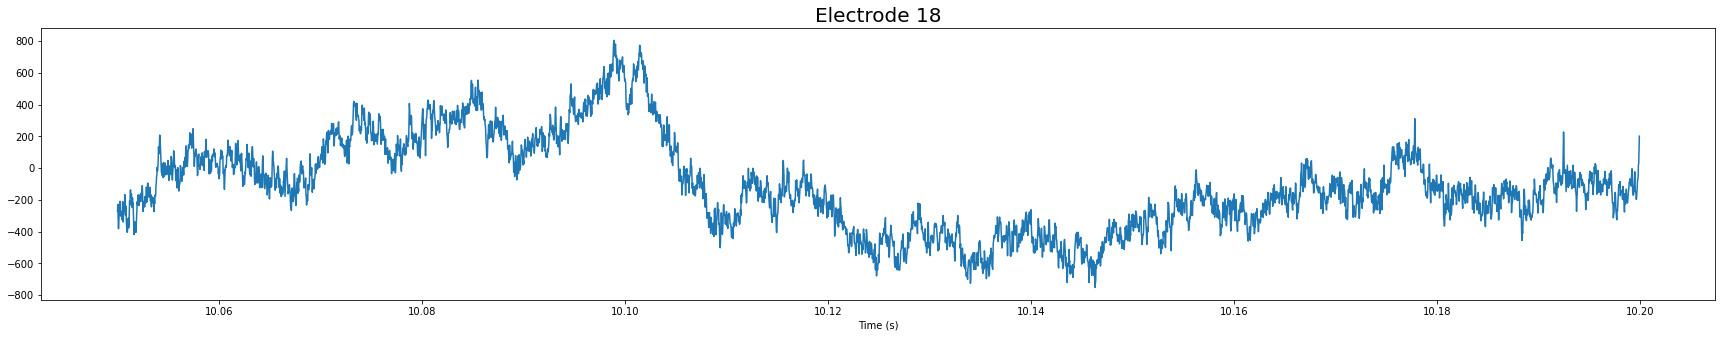

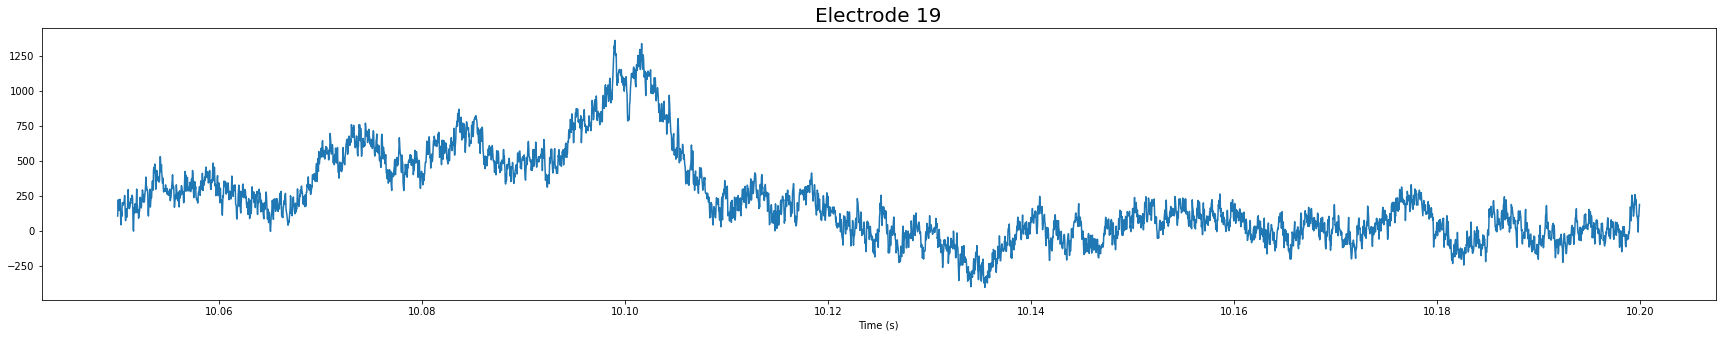

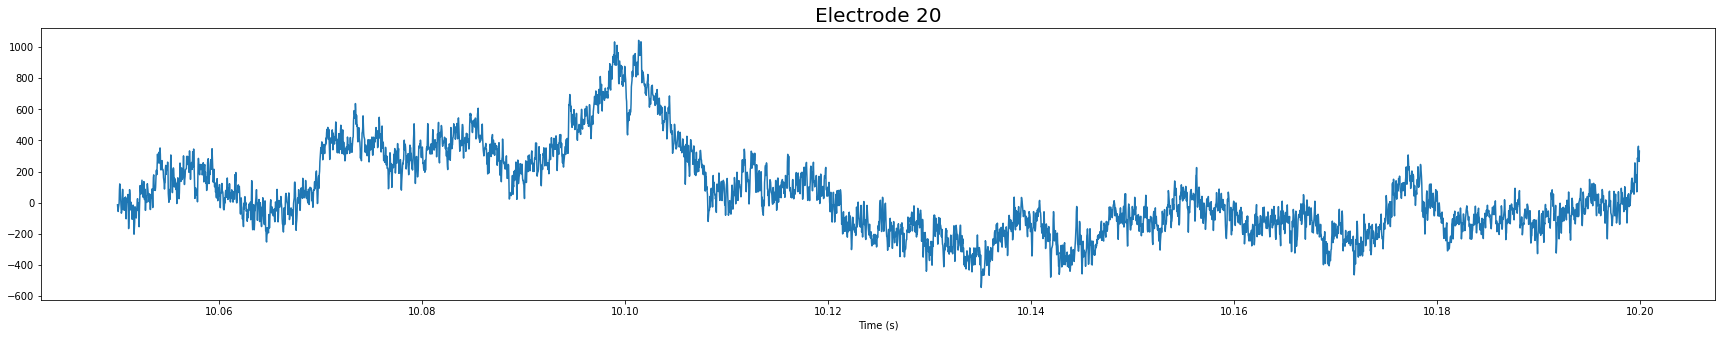

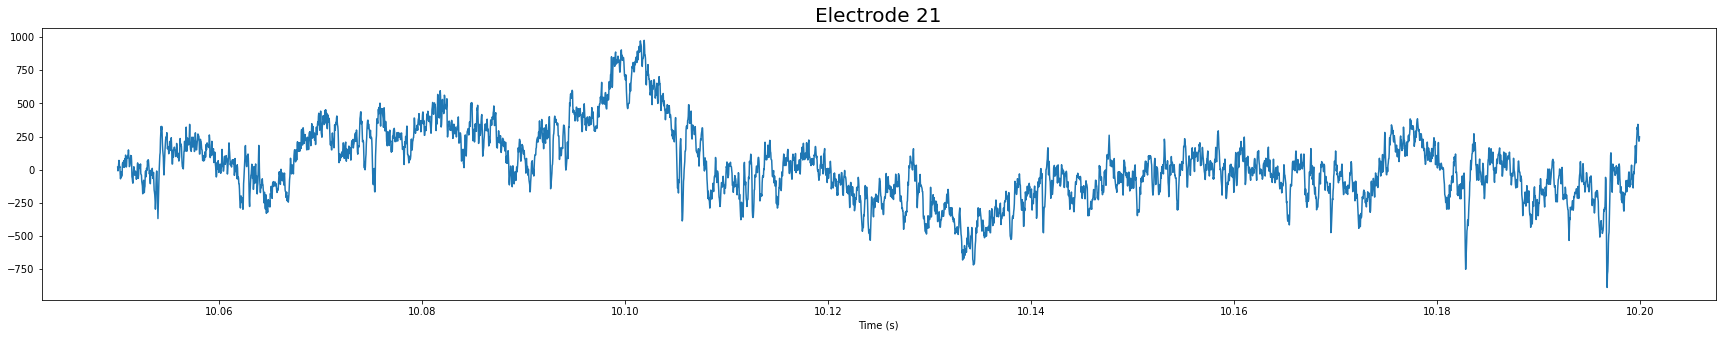

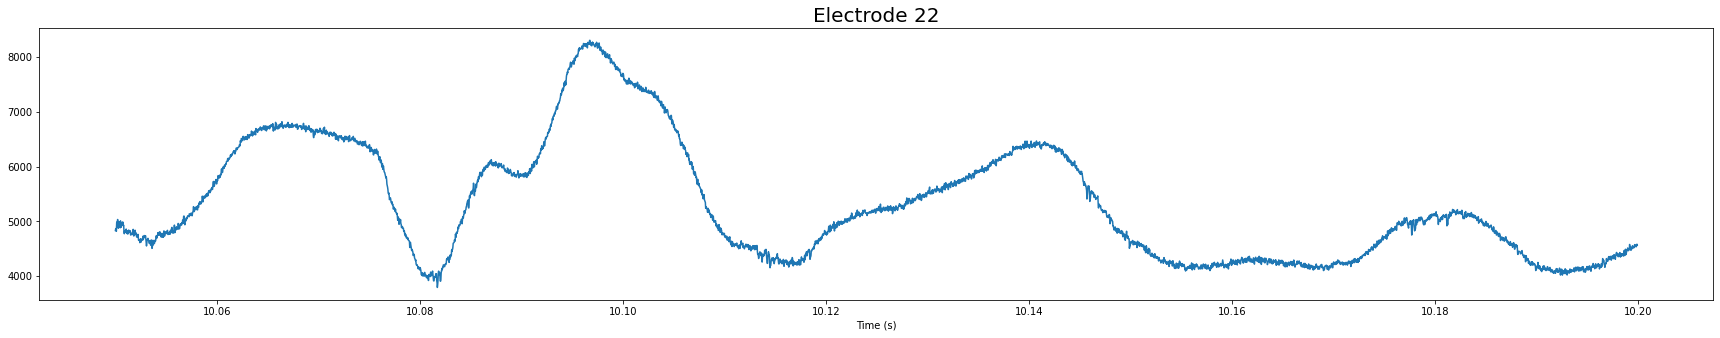

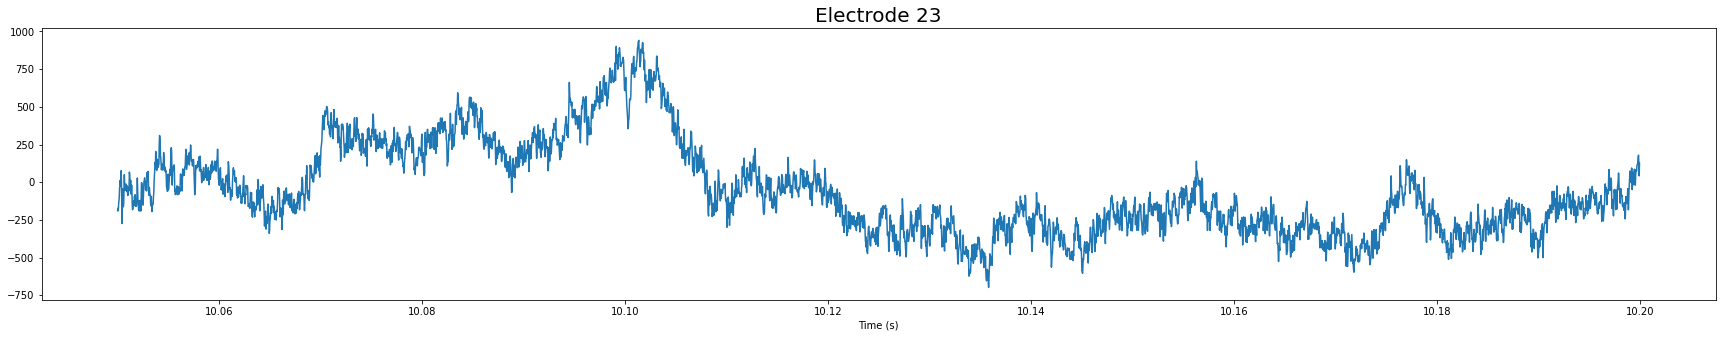

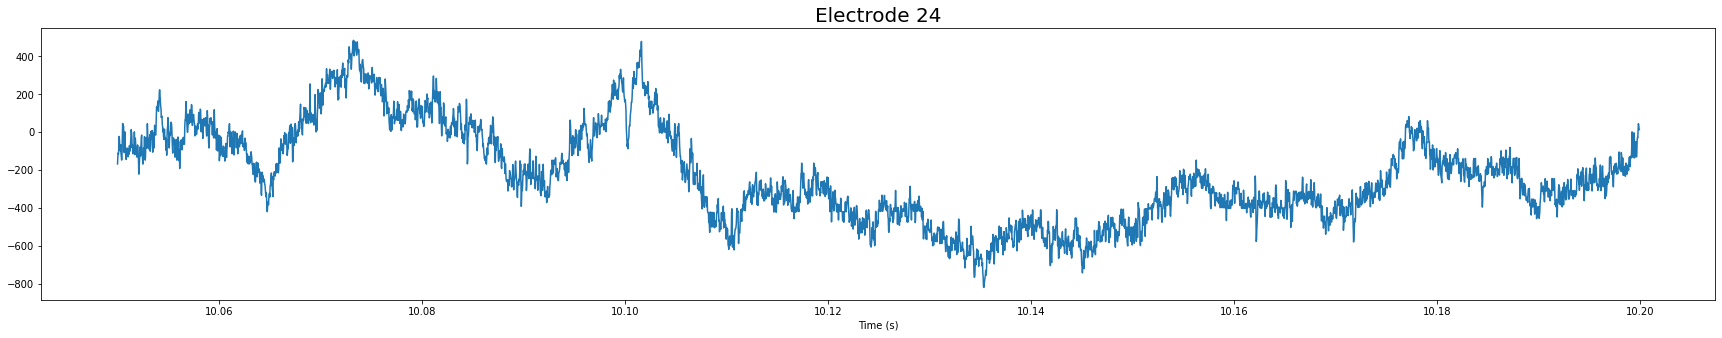

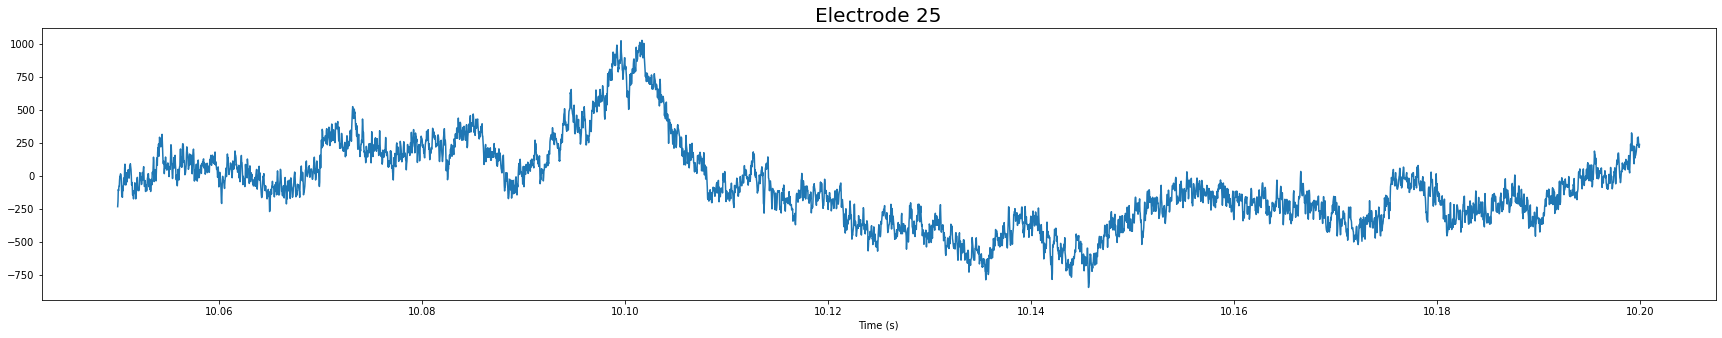

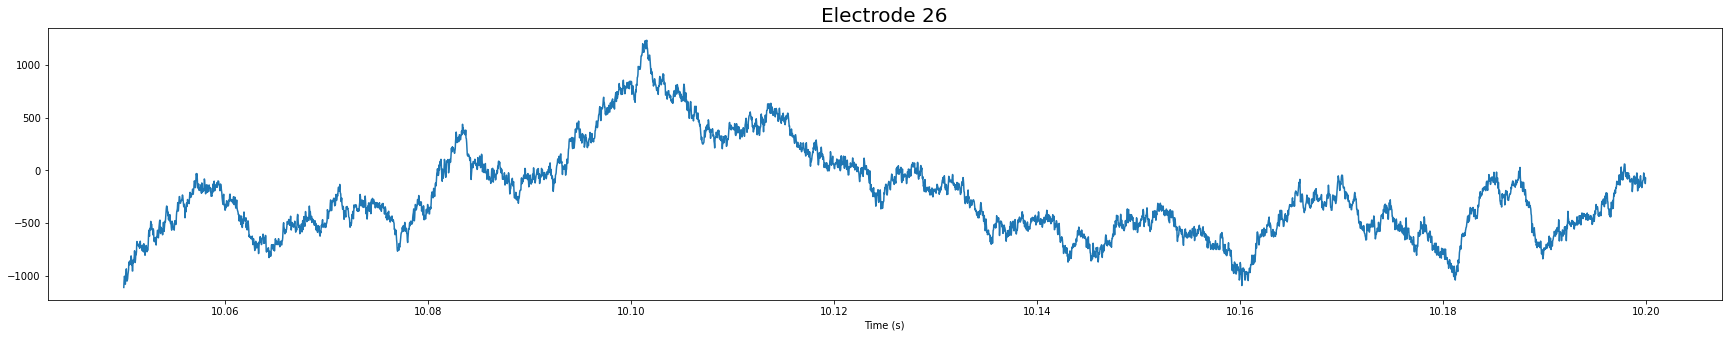

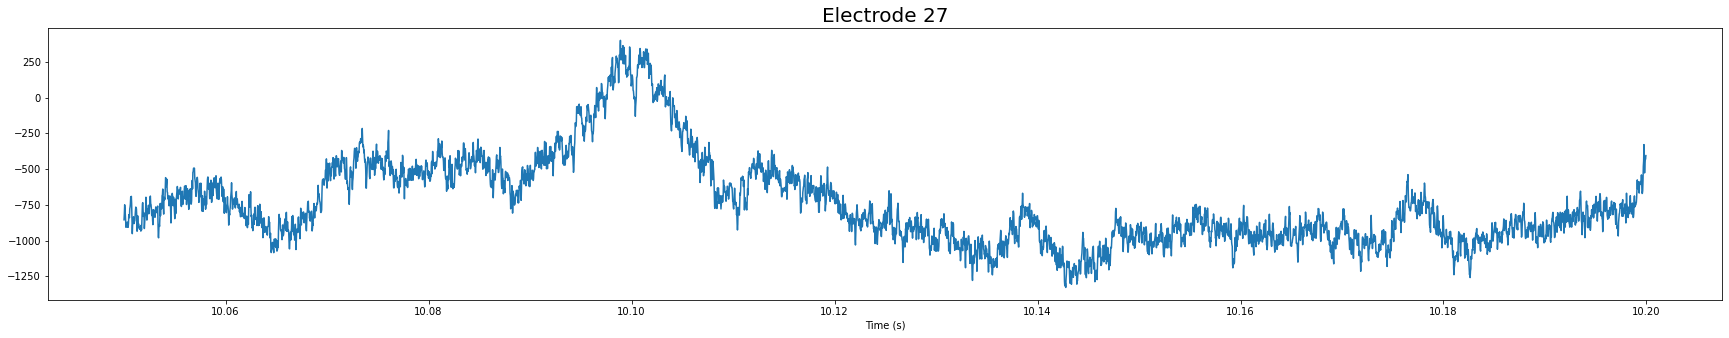

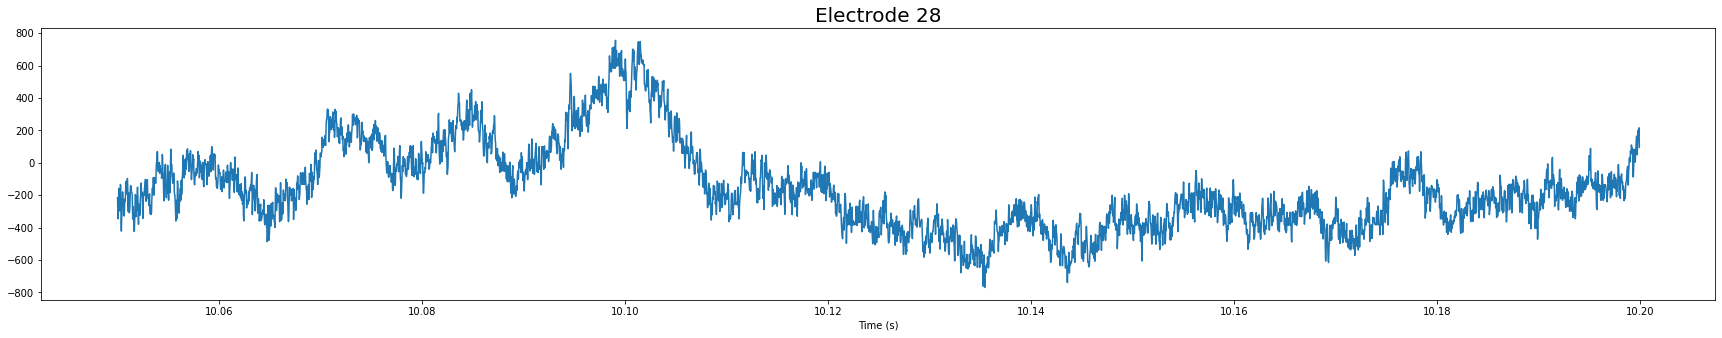

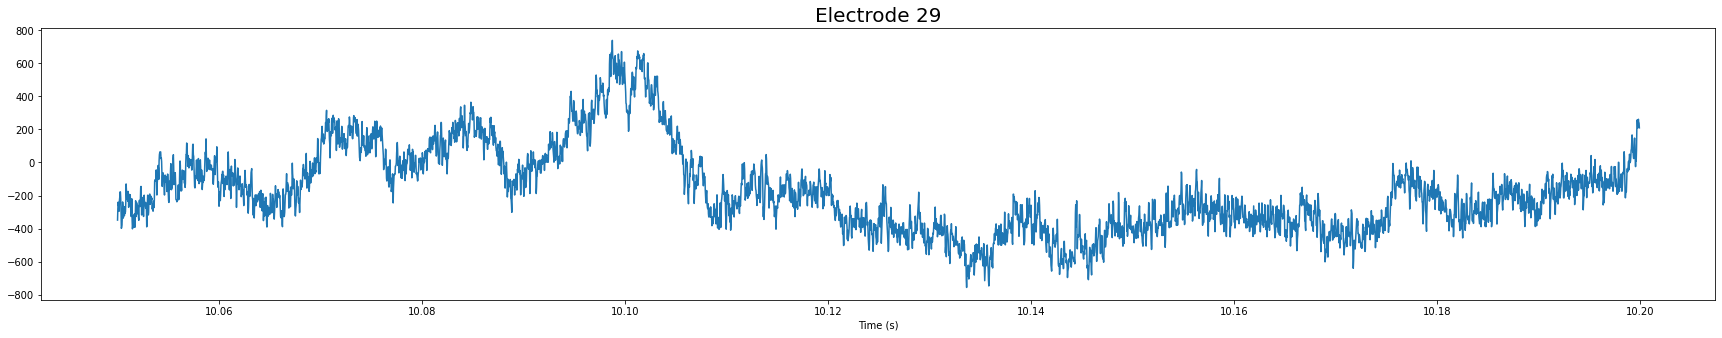

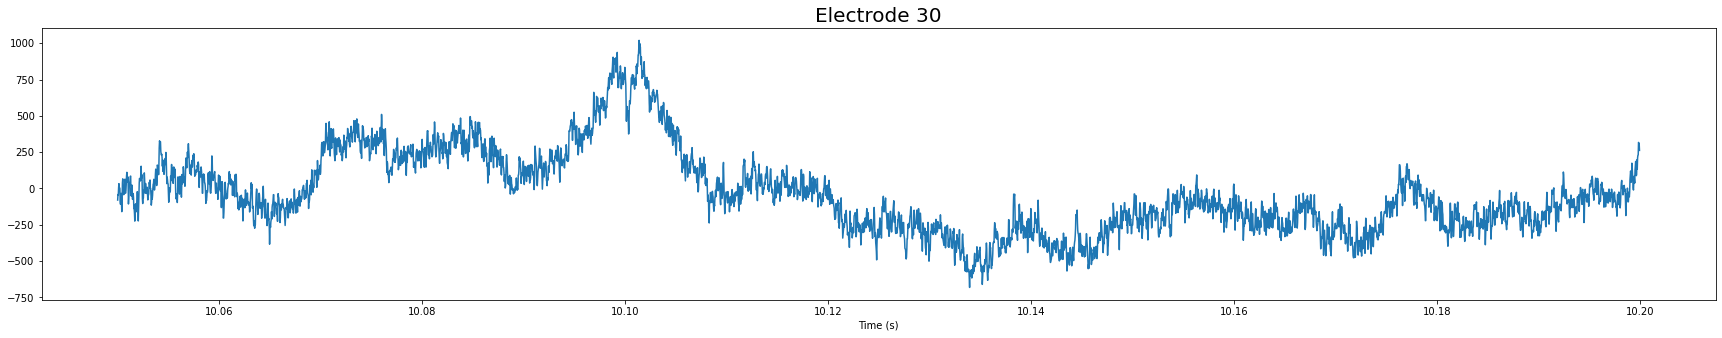

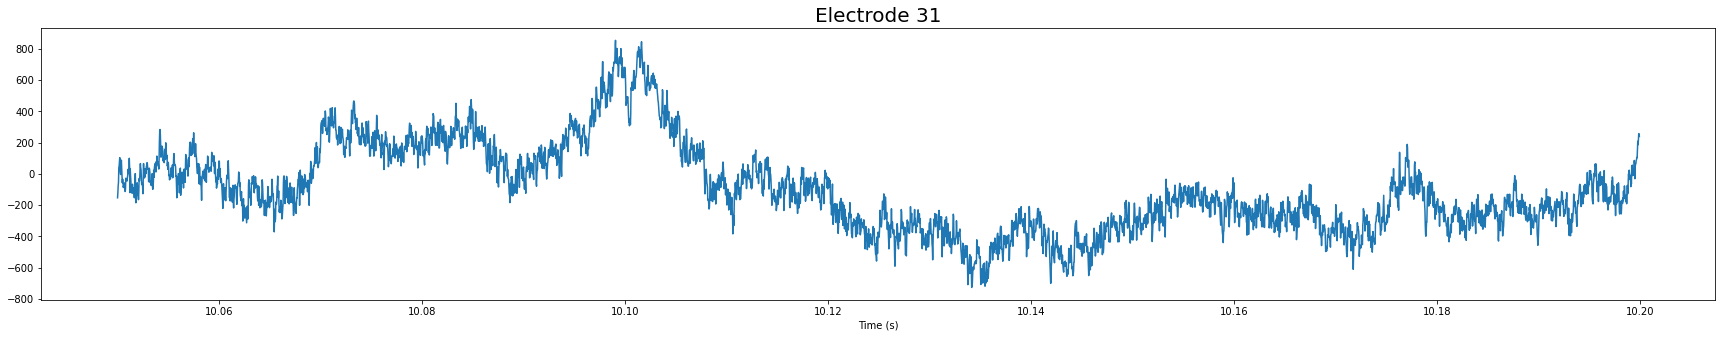

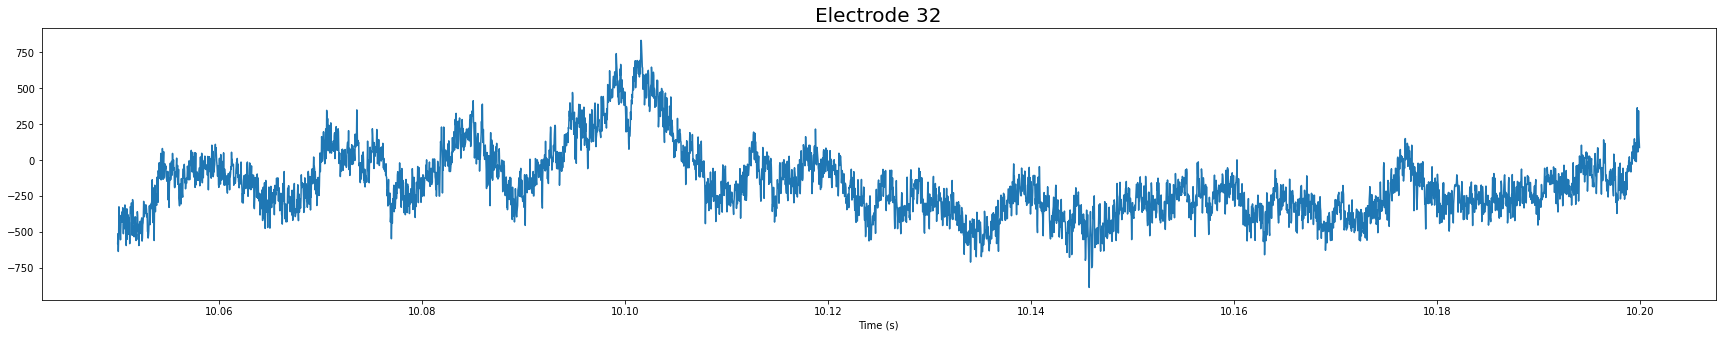

ThemisDB.csv has been updated


In [8]:
badElecList =[]
# Present all electrodes
for elec in elecList:
    showElectrode(os.path.join(inDir+"binNew","Elec"+str(elec)+rangeStr+".bin"),elec,[10.05,10.2],"")
    # Ask for an answer from the user
    result = input("Enter good/bad: ")
    if str(result)=="bad":
        badElecList.append(elec)
        # remove bad electrode from elecList
        elecList.remove(elec)
# updates the bad electrodes
basicRow.update({"Bad electrodes":badElecList})
updateDB(basicRow)

d:\users\matan\documents\pycharmprojects\preprocess\venv\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


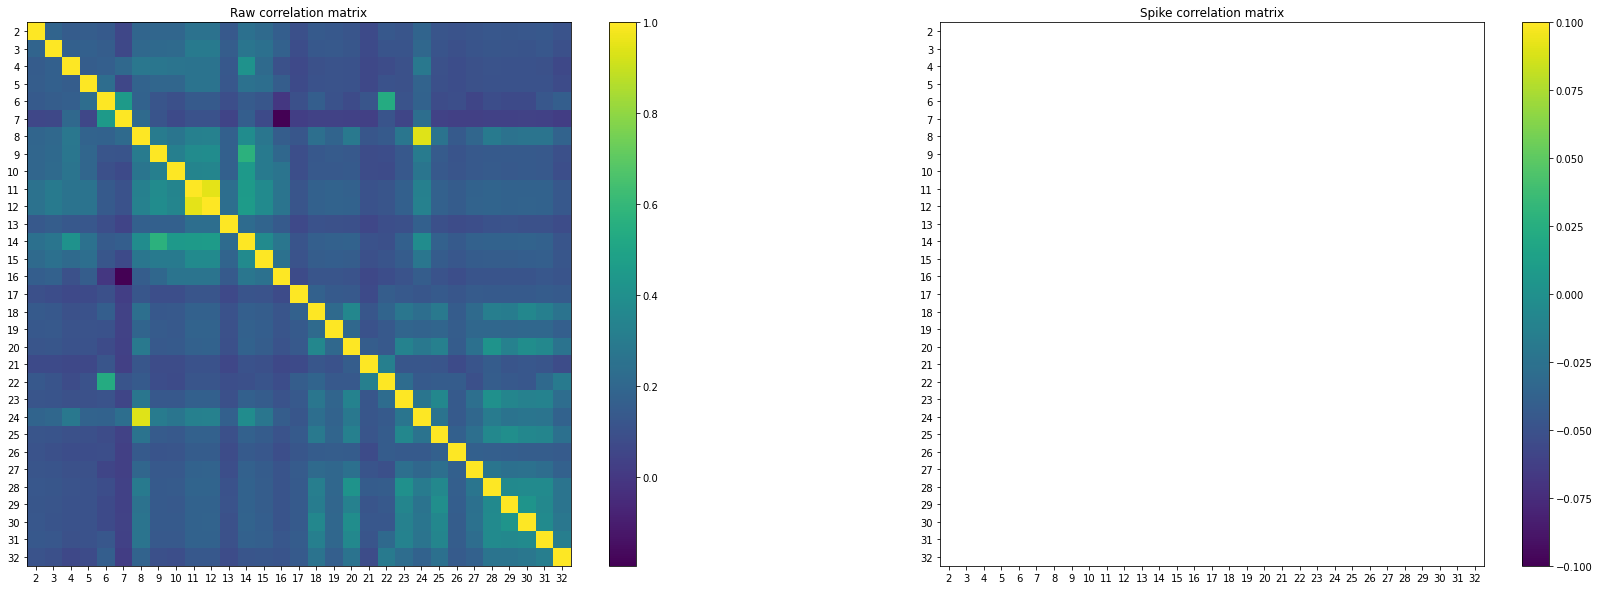

Not all values are numbers! Please enter again
ThemisDB.csv has been updated


In [4]:
ccr, ccf = pp.plot_corr_mat(inDir,rangeStr,elecList,raw_fold="binNew")
matplotlib.pyplot.show()
result = input("Enter channels with crosstalk (a,b,c...) or write stop to finish: ")
lisOfNumLists = []
while result != "stop":
    # split the result by ','
    strList = result.split(',')
    try:
        # try to convert each string to an int
        numList = list(map(lambda string: int(string), strList))
        lisOfNumLists.append(numList)
    except ValueError:
        # if not all strings can be converted, print an error message
        print("Not all values are numbers! Please enter again")
    # ask for a user input again
    result = input("Enter channels with crosstalk (a,b,c...) or write stop to finish: ")
# update the DB
basicRow.update({"Crosstalk": lisOfNumLists})
updateDB(basicRow)

In [4]:
pp.remScaledMedian(inDir + "binBand\\", inDir + "binMed\\", elecList, rangeStr)
basicRow.update({"median": elecList.__len__()})
updateDB(basicRow)
print(str(elecList.__len__()) + " files removed their median successfully")


[array([0.78790386]), array([0.73040914]), array([0.81573548]), array([0.70859863]), array([0.35977197]), array([0.93451692]), array([0.95998774]), array([0.76625921]), array([0.74213258]), array([0.7044846]), array([0.70784913]), array([0.62309481]), array([0.76870704]), array([0.72000254]), array([0.58487045]), array([0.72400883]), array([1.08447409]), array([0.86202981]), array([1.11237669]), array([0.89425104]), array([0.44231514]), array([1.08603913]), array([0.96939307]), array([1.03651925]), array([0.59390266]), array([0.88101878]), array([1.1028371]), array([1.06973997]), array([1.11917537]), array([1.10439298]), array([1.0102654])]
ThemisDB.csv has been updated
31 files removed their median successfully


In [5]:
def plot5Sec(filePath, axes, elec, samplingRate=32000):
    maxX = axes[1].dataLim.intervalx[1]
    time = maxX / samplingRate
    start = [0, 5]
    end = [time - 5, time]
    middle = [(time / 2) - 2.5, (time / 2) + 2.5]
    showElectrode(filePath, elec, start, " Start")
    showElectrode(filePath, elec, middle, " Middle")
    showElectrode(filePath, elec, end, " End")

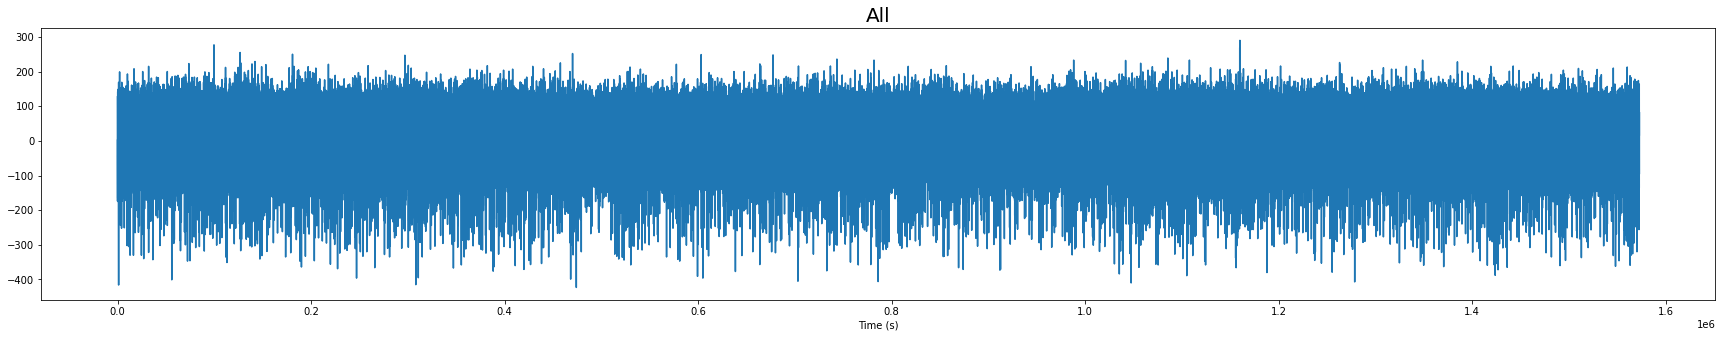

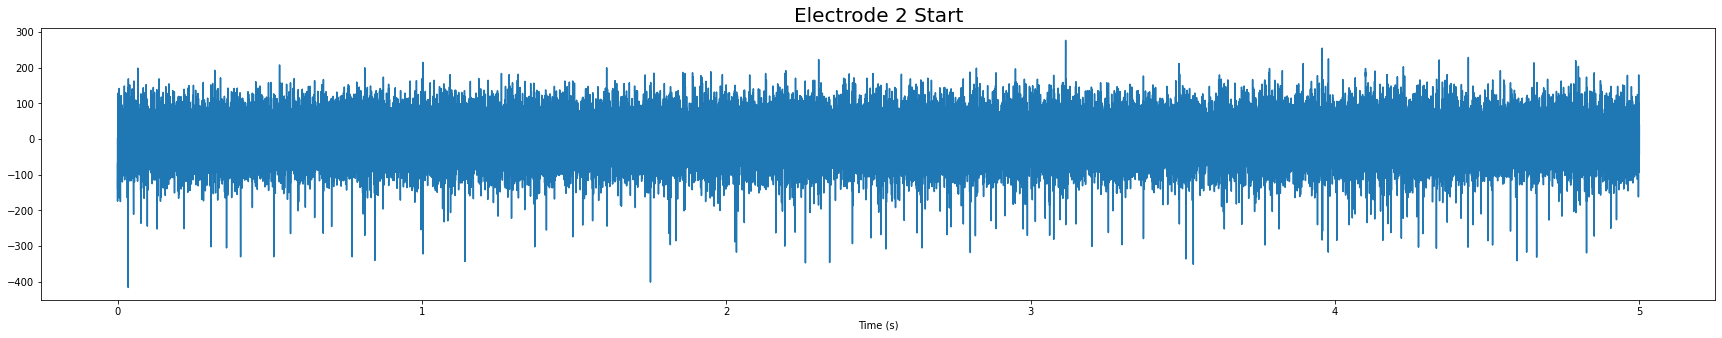

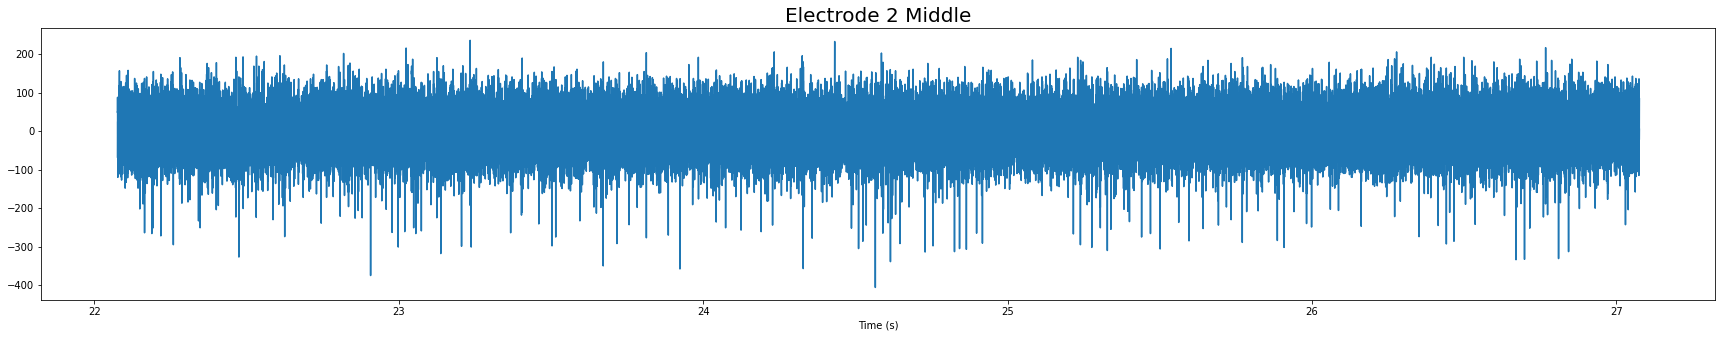

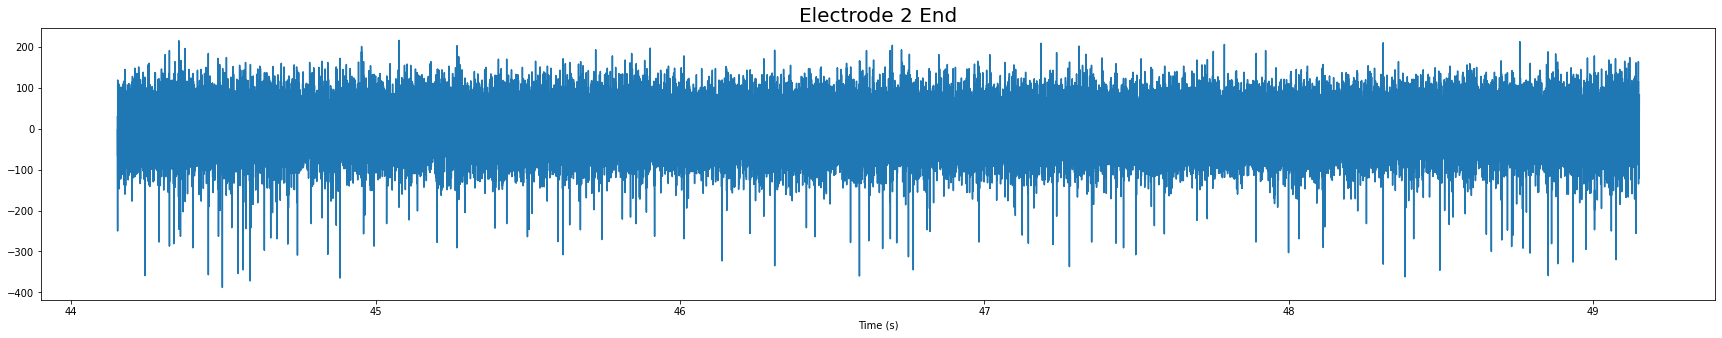

Is possible unit? (yes/no): yes


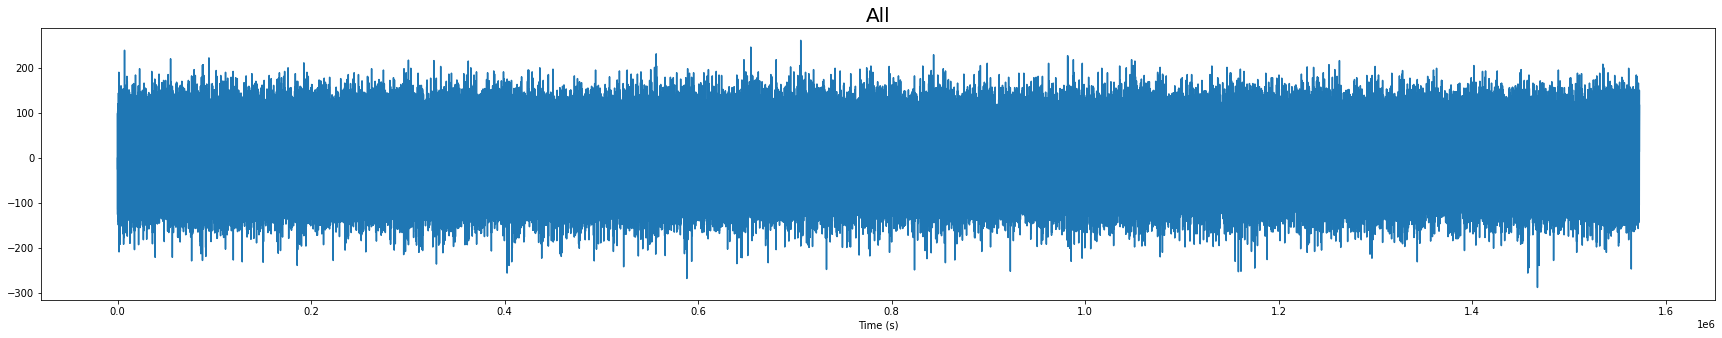

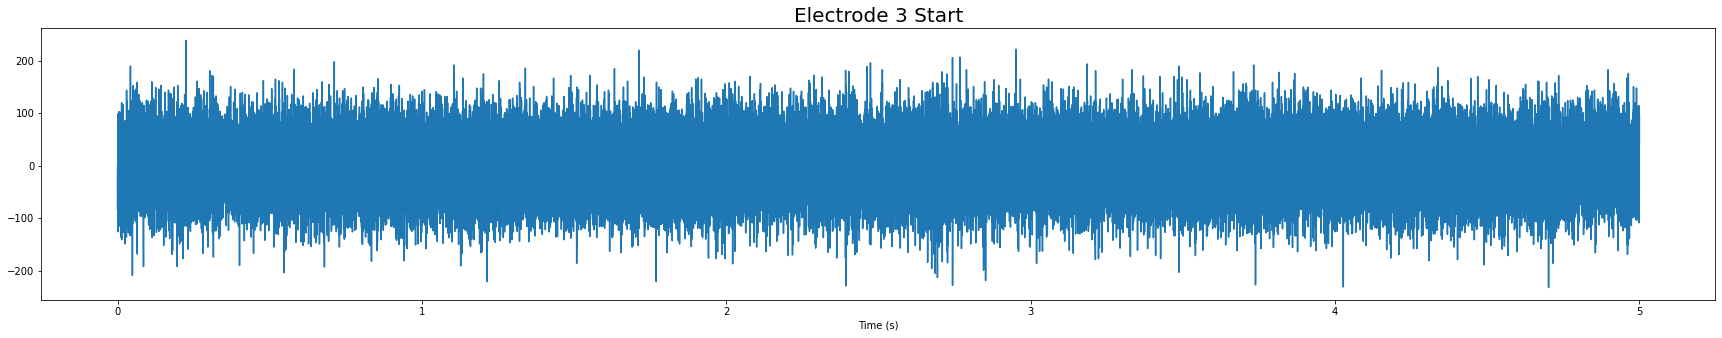

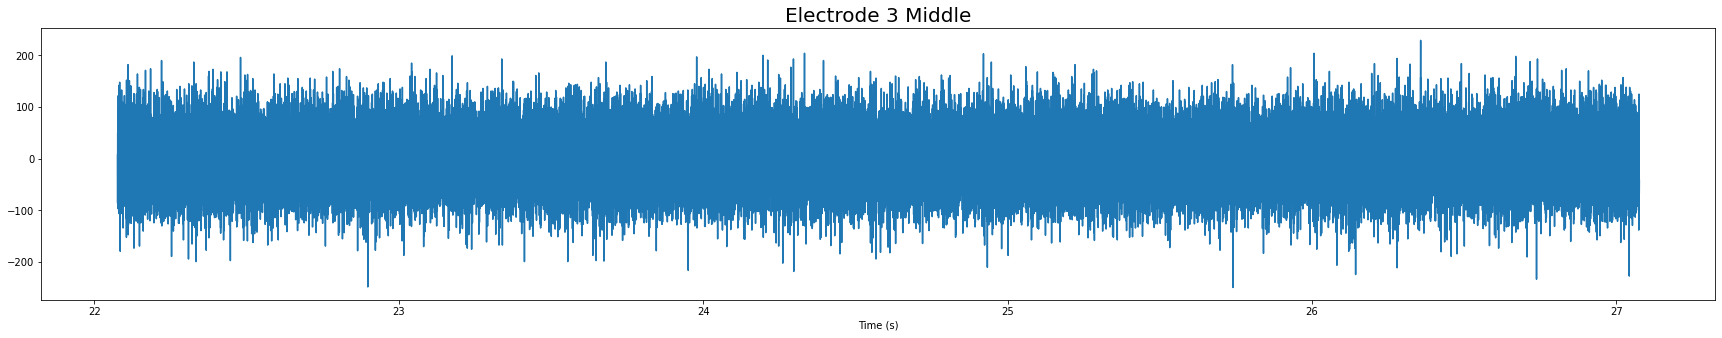

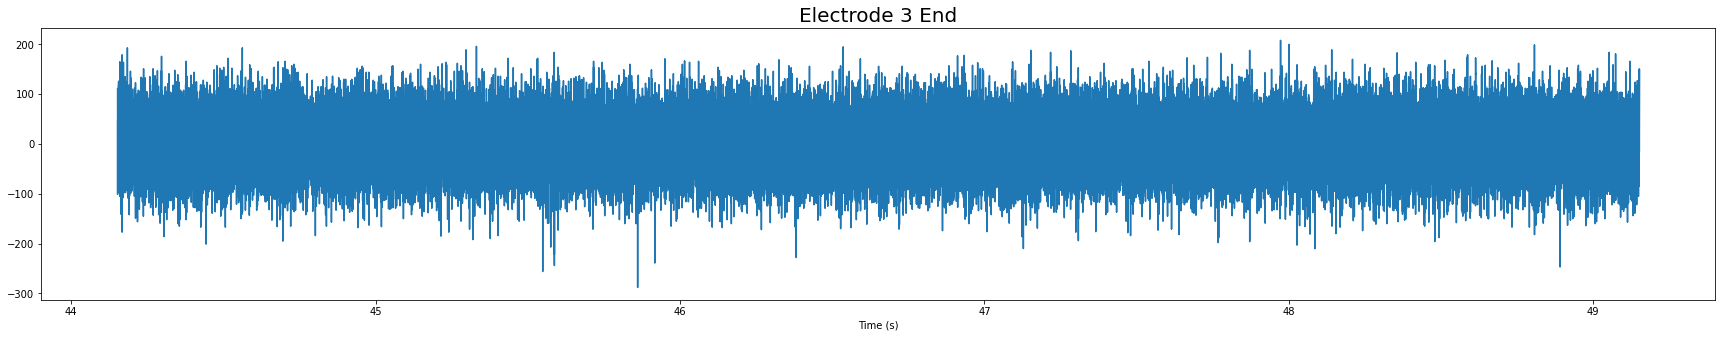

Is possible unit? (yes/no): no


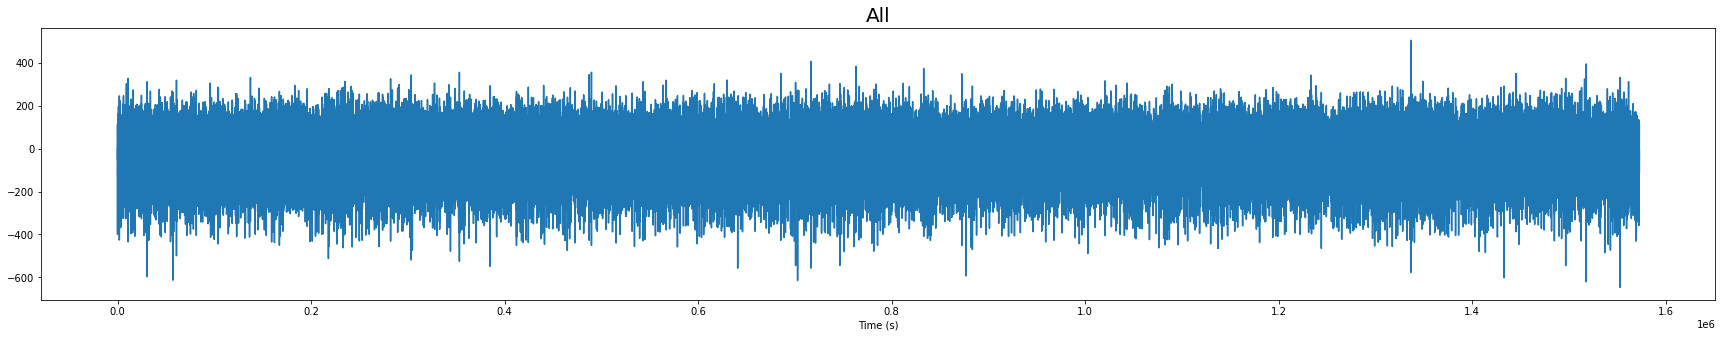

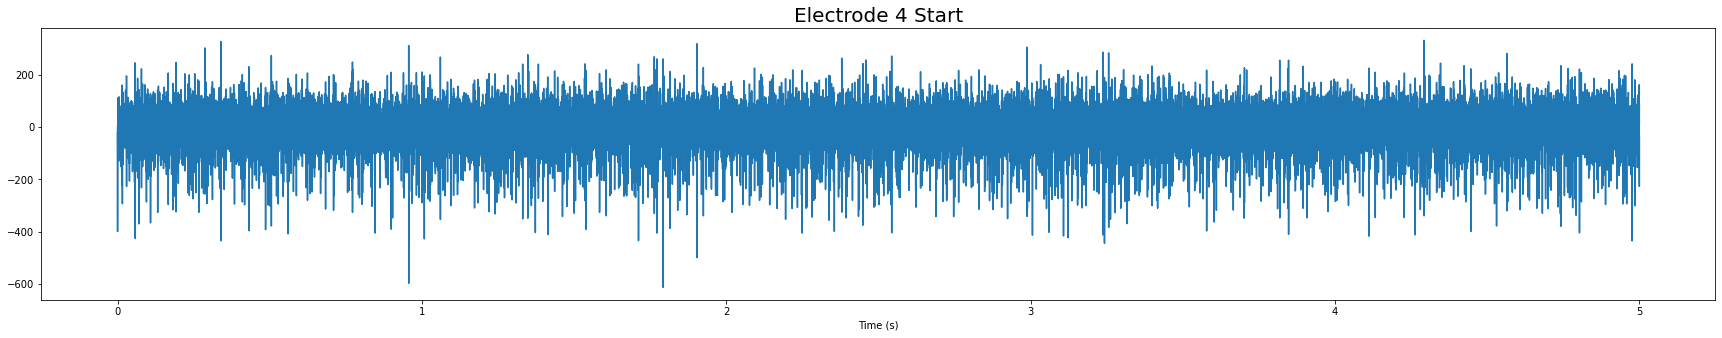

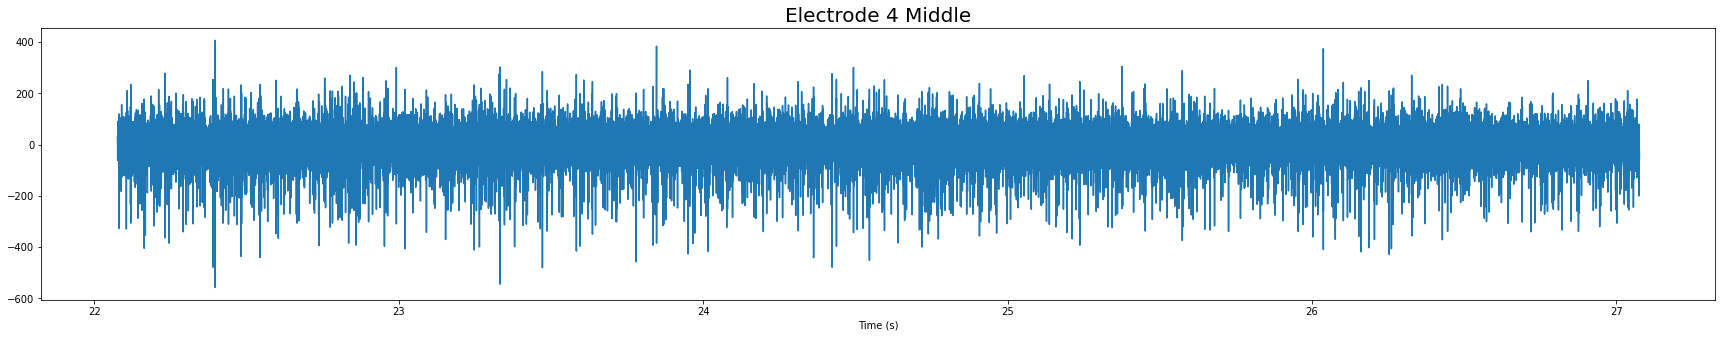

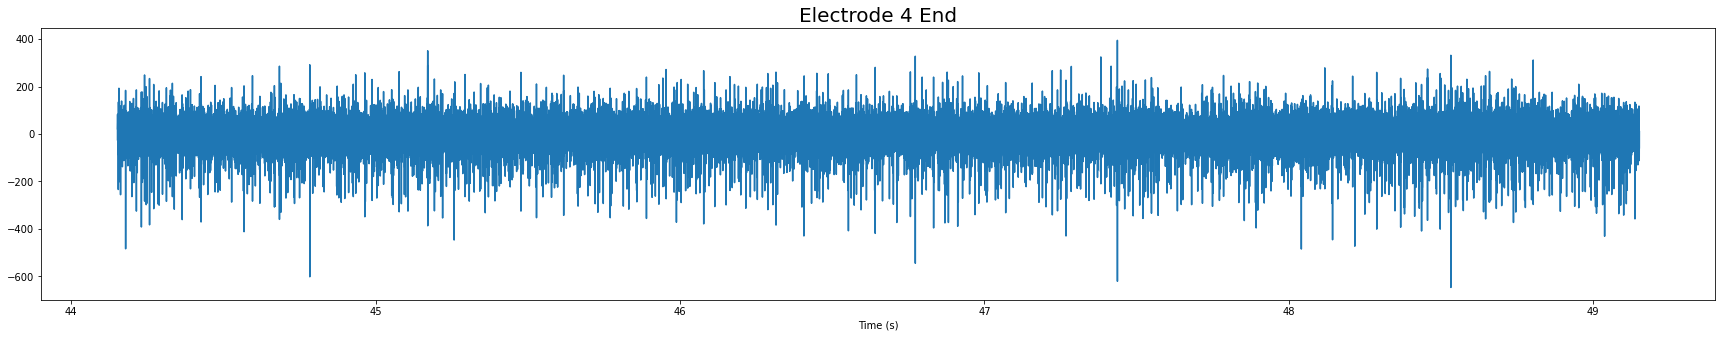

Is possible unit? (yes/no): yes


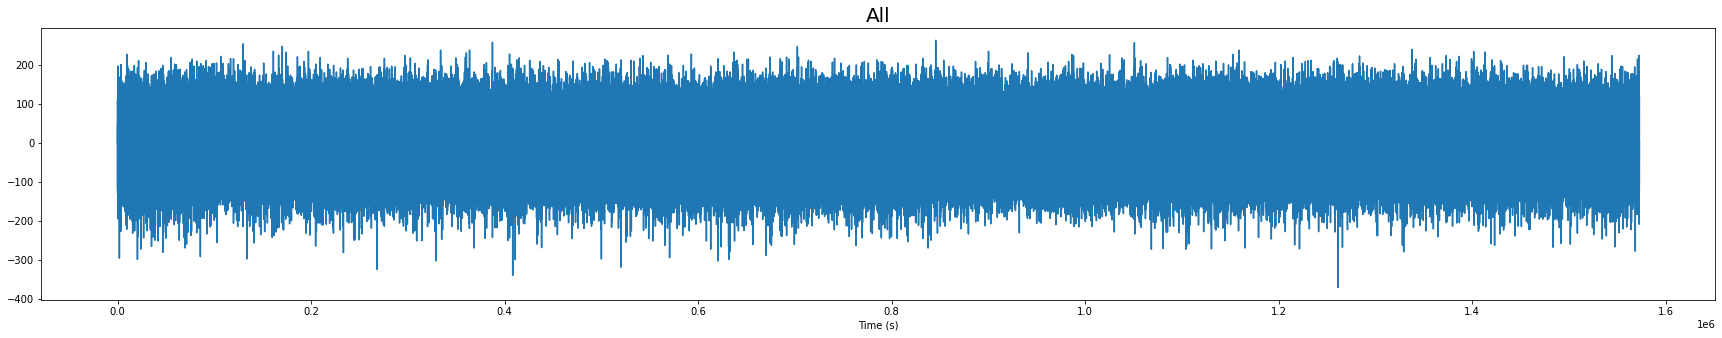

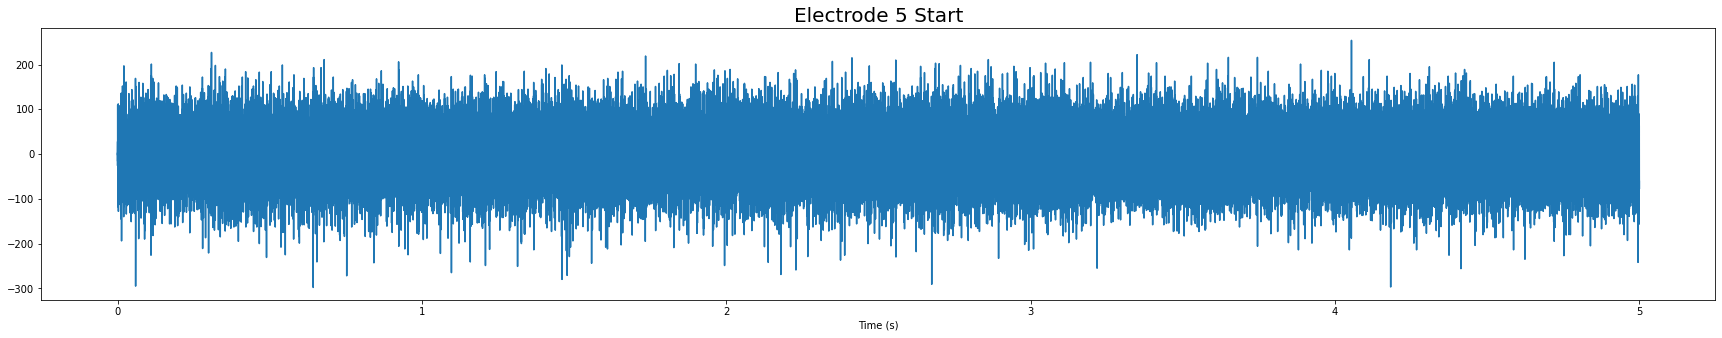

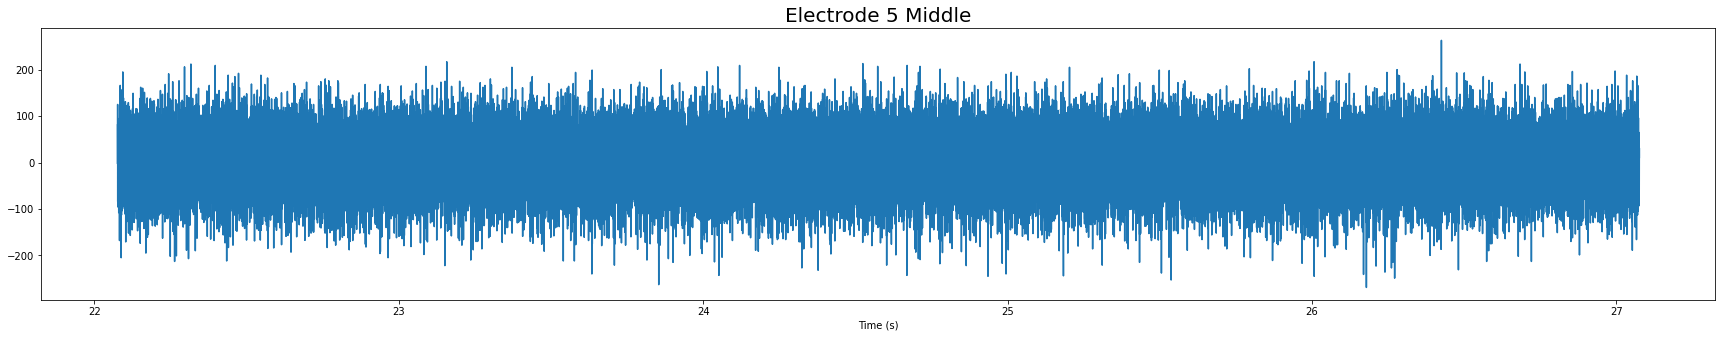

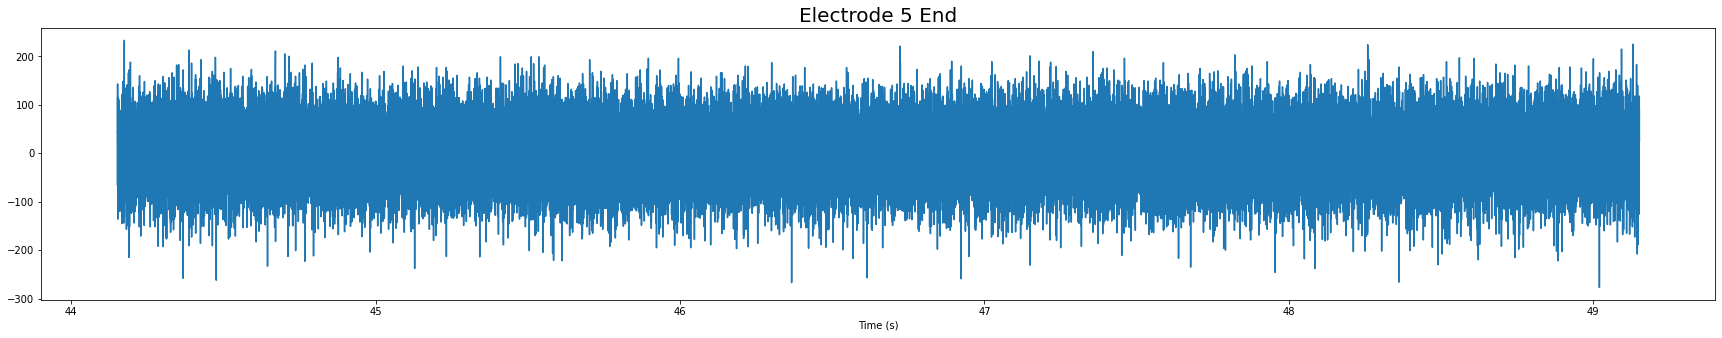

Is possible unit? (yes/no): 


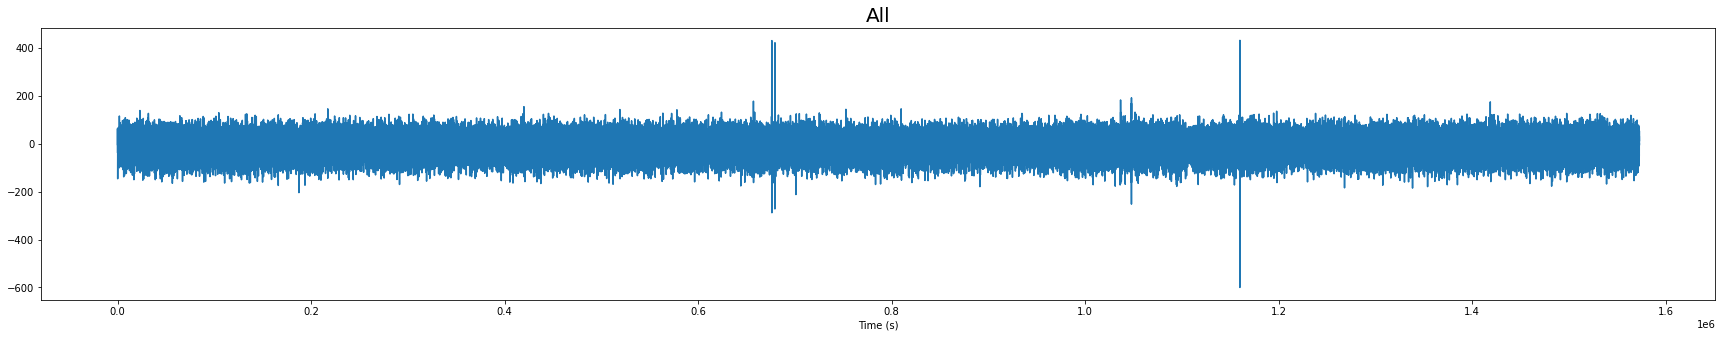

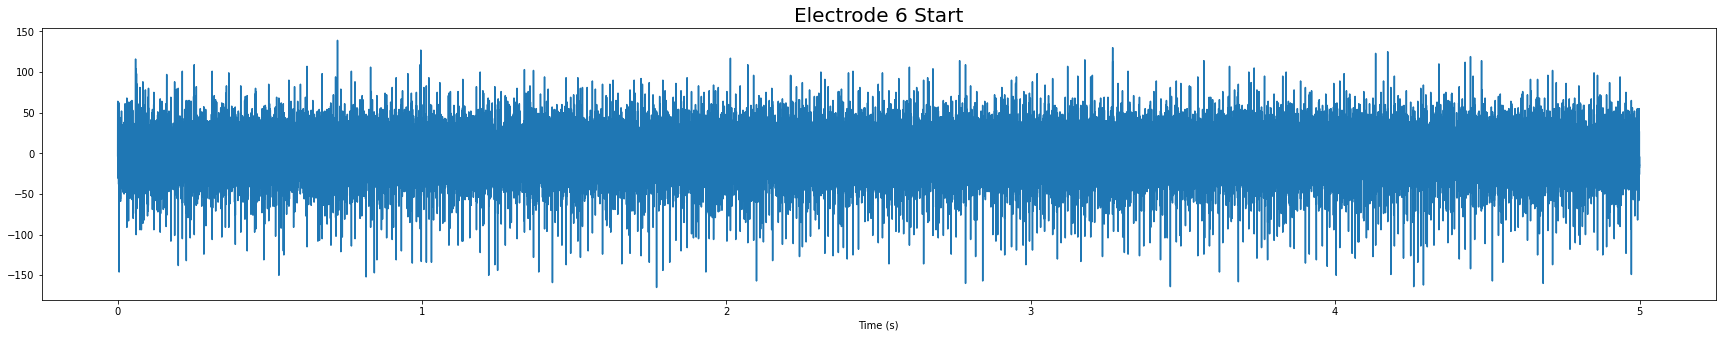

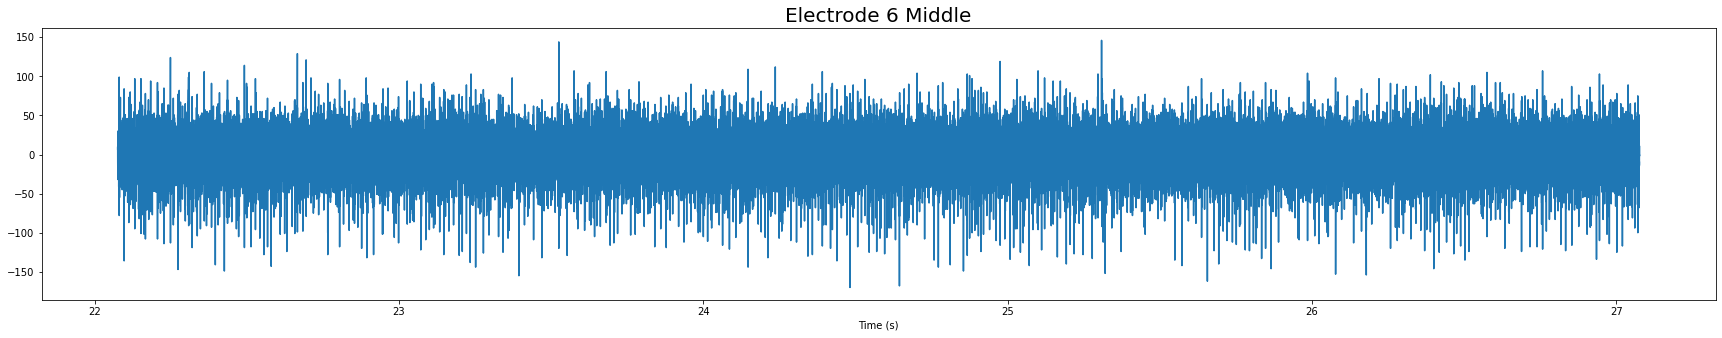

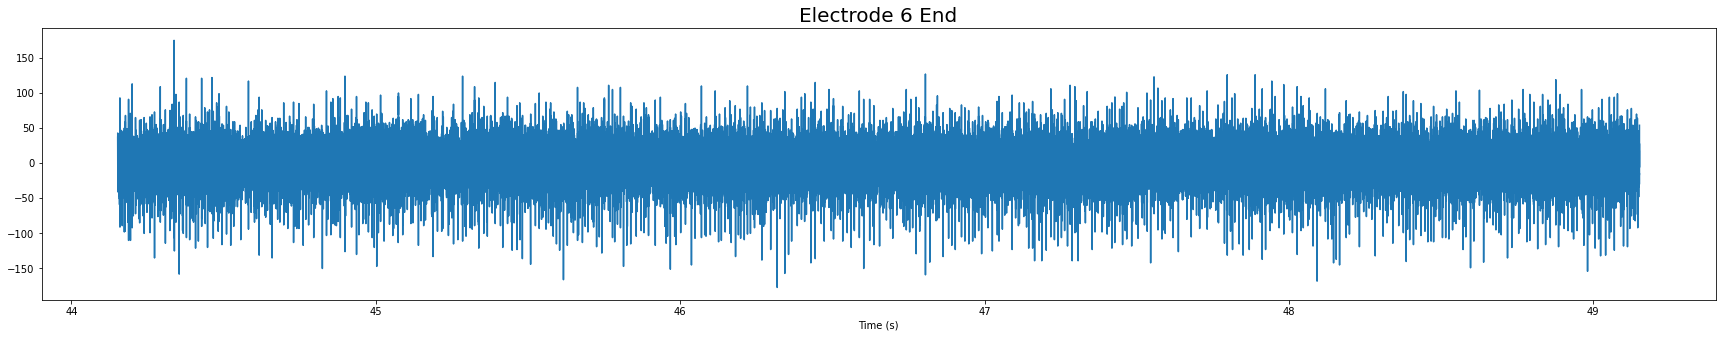

Is possible unit? (yes/no): 


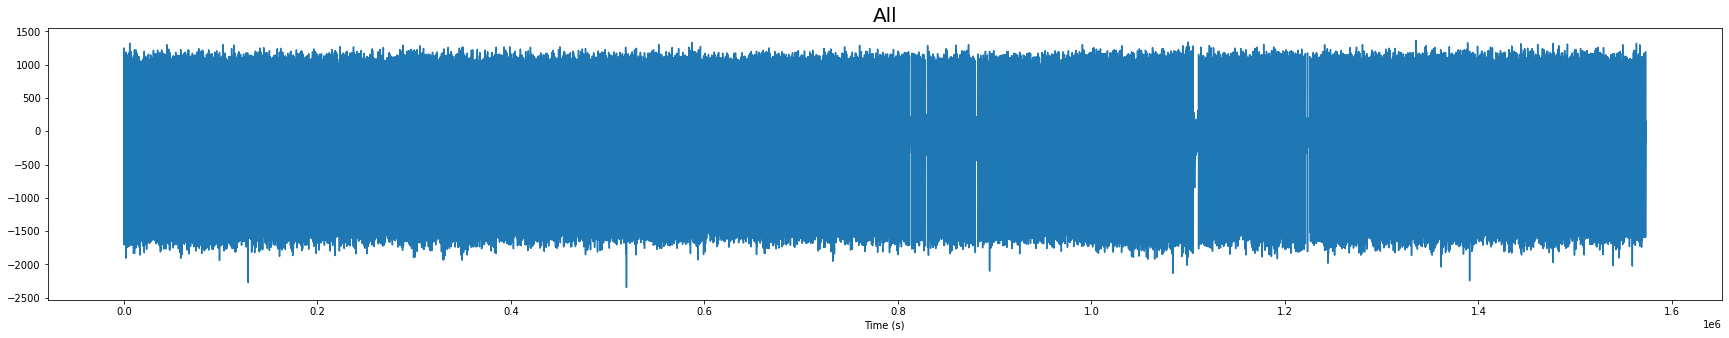

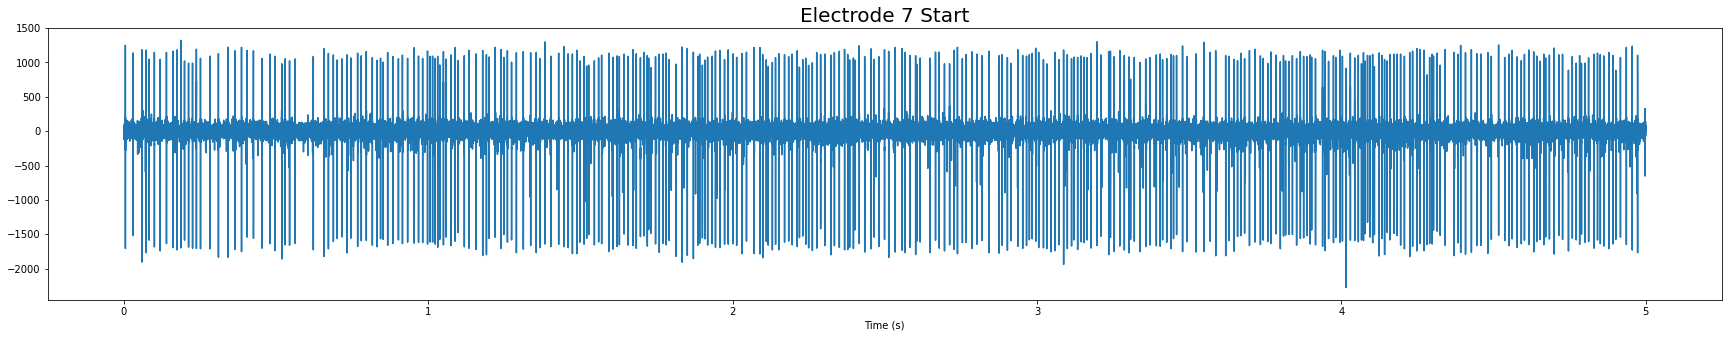

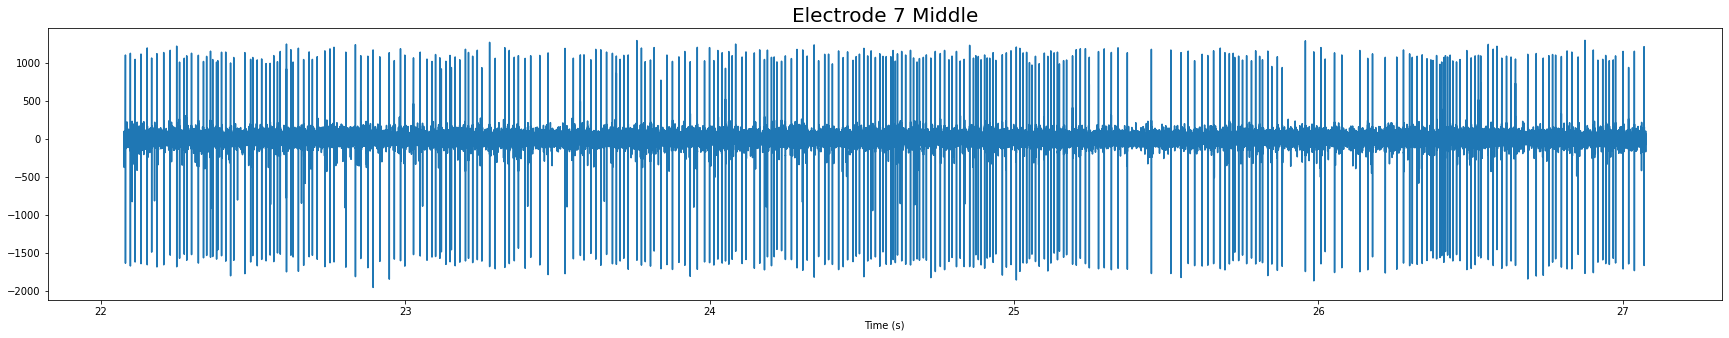

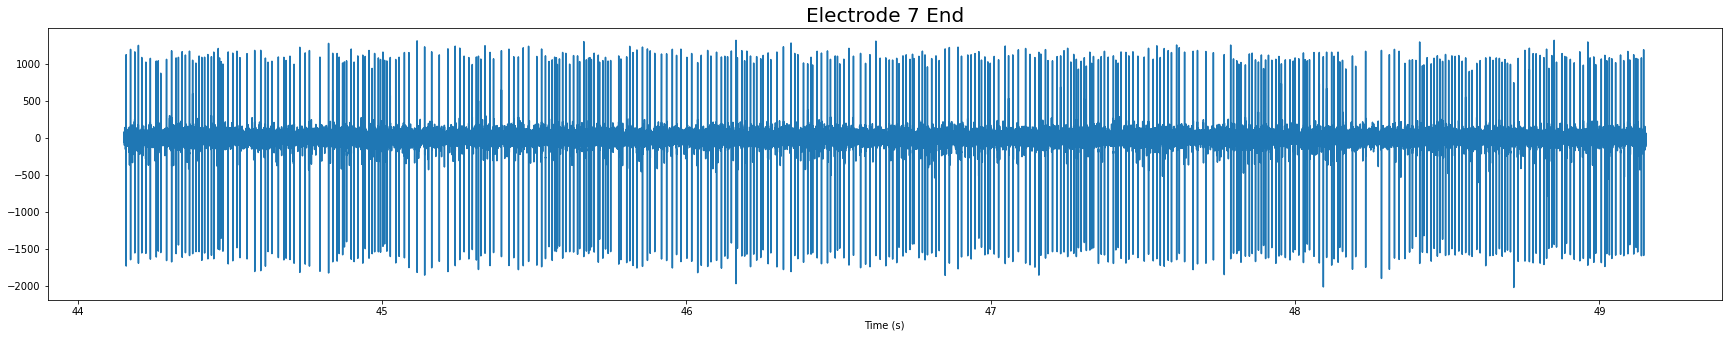

Is possible unit? (yes/no): 


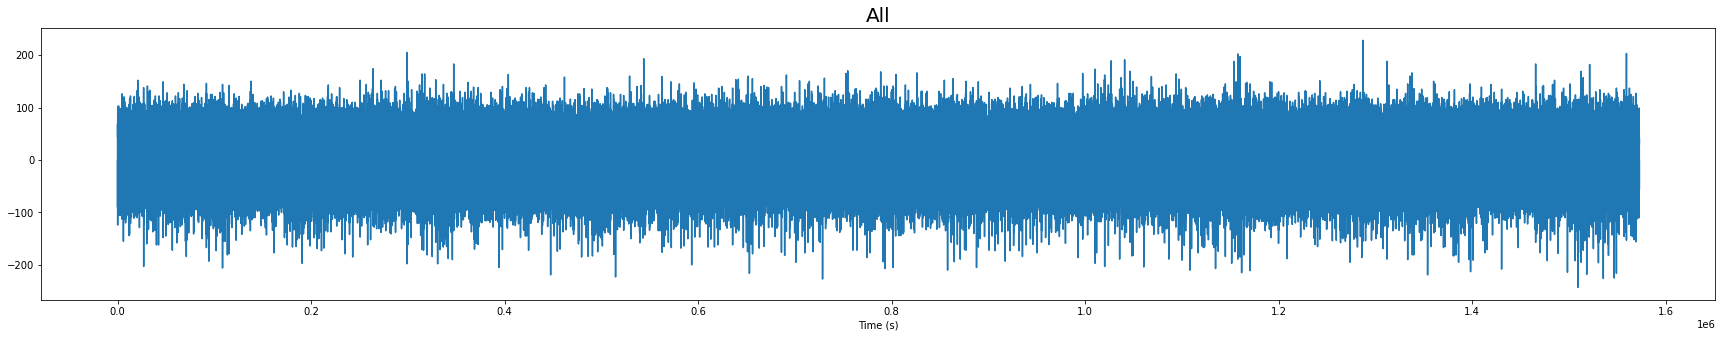

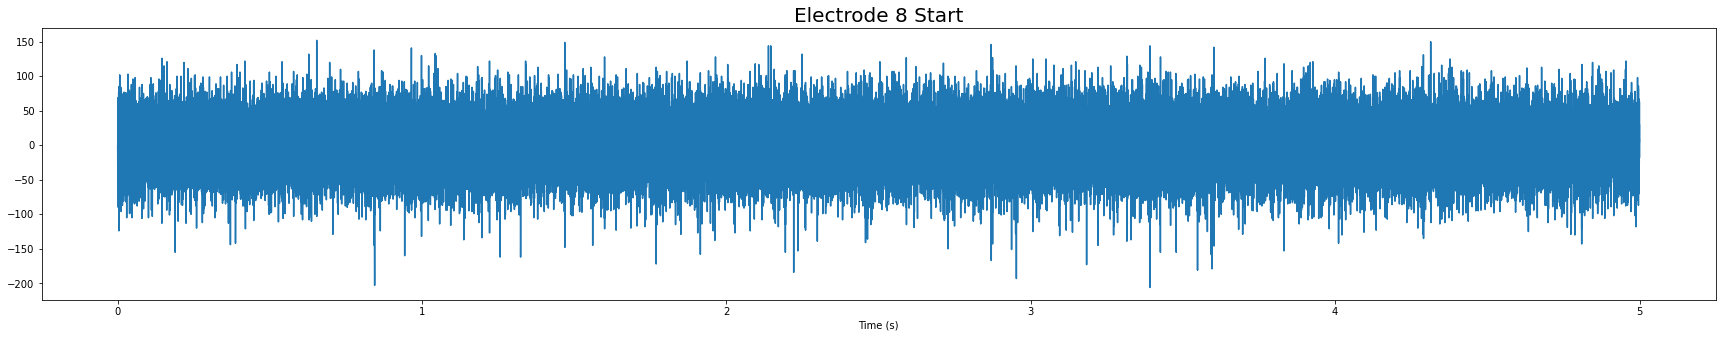

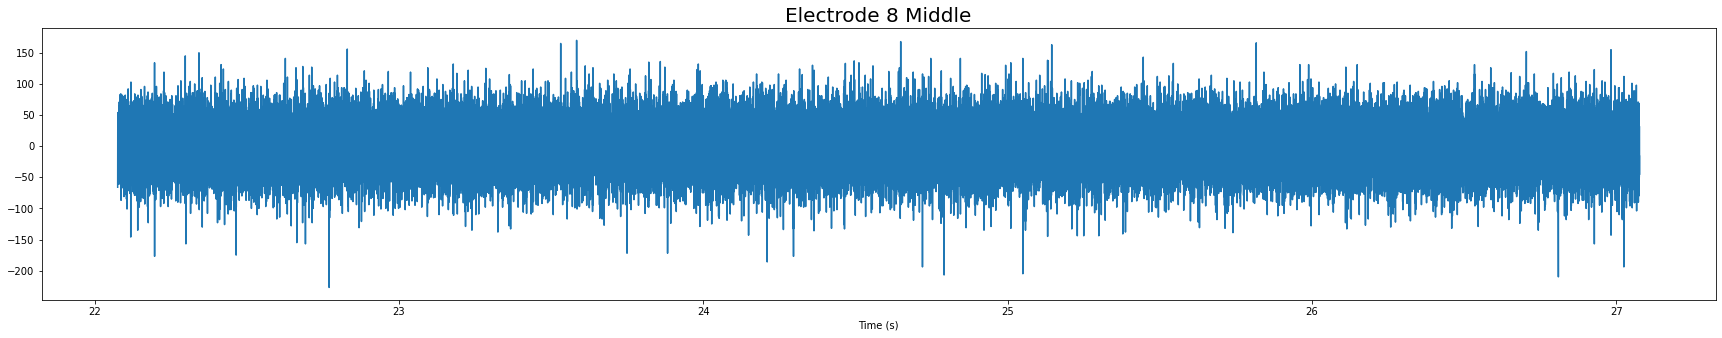

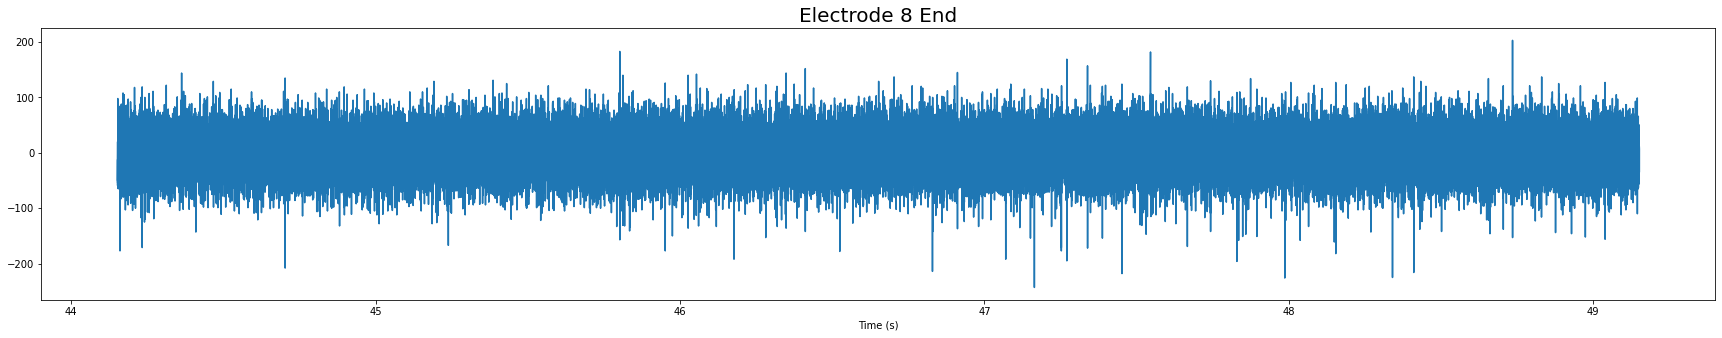

Is possible unit? (yes/no): 


MemoryError: 

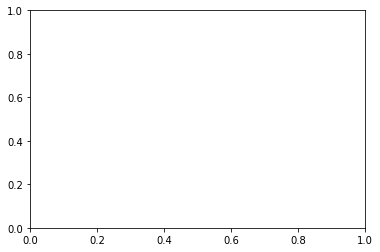

In [6]:
unitsList = []
for elec in elecList:
    filePath = os.path.join(inDir, "binMed\\", 'Elec' + str(elec) + rangeStr + '.bin')
    axes = pp.plotAllBin(filePath)
    plot5Sec(filePath, axes, elec)
    result = input("Is possible unit? (yes/no)")
    if result == "yes":
        unitsList.append(elec)
basicRow.update({"possible spiking channels": unitsList})
updateDB(basicRow)